In [1]:
import pandas as pd
import seaborn as sns
from joblib import dump, load

In this project we tried a few different approaches before encountering one in which we could progress. This is caused by the broadness of our dataset, which allows for a lot of questions. Some of this questions uncover very interesting relationships in the data, but unfortunately some other questions lead us to dead ends, at least with the data and time we have available. 

Our first idea was to predict the tapping temperature of a batch of metal based on the energy usage of the furnace for such metal.

This relationship, if strong, could have been used to optimize the energy consumage of the EAF and stabilize the temperature values even further (they are already really stable, probably the most stable variable in the furnace's dataset)

We start by doing some preprocessing on the temperature data.

In [2]:
df=pd.read_csv('eaf_temp.csv', sep=',')

print(df)

       HEATID             DATETIME    TEMP  VALO2_PPM
0      6F0020  2016-01-01 19:15:00  1650.0     1242.0
1      6F0021  2016-01-01 20:05:00  1649.0     1160.0
2      6F0021  2016-01-01 20:05:00  1649.0     1160.0
3      6F0021  2016-01-01 20:03:00  1606.0     1152.0
4      6F0022  2016-01-01 21:03:00  1636.0      947.0
...       ...                  ...     ...        ...
85099  5F8441  2015-12-31 21:53:00  1653.0        0.0
85100  5F8441  2015-12-31 21:54:00  1650.0     1133.0
85101  5F8441  2015-12-31 21:52:00  1603.0        0.0
85102  5F8442  2015-12-31 22:38:00  1667.0     1253.0
85103  5F8442  2015-12-31 22:37:00  1633.0        0.0

[85104 rows x 4 columns]


In [ ]:
#analyze duplicates
df_duplicates=df[df.duplicated(keep=False)]
print("number of rows =", len(df)) 
print("number of duplicated rows =", len(df_duplicates))
print(df_duplicates) 

number of rows = 85104
number of duplicated rows = 3520
       HEATID             DATETIME    TEMP  VALO2_PPM
1      6F0021  2016-01-01 20:05:00  1649.0     1160.0
2      6F0021  2016-01-01 20:05:00  1649.0     1160.0
20     6F0028  2016-01-02 03:25:00  1651.0     1048.0
21     6F0028  2016-01-02 03:25:00  1651.0     1048.0
94     6F0053  2016-01-03 00:27:00  1500.0       17.0
...       ...                  ...     ...        ...
84966  5F8403  2015-12-30 01:53:00  1621.0      845.0
85036  5F8427  2015-12-31 00:53:00  1663.0        0.0
85037  5F8427  2015-12-31 00:53:00  1663.0        0.0
85045  5F8429  2015-12-31 03:51:00  1574.0        0.0
85046  5F8429  2015-12-31 03:51:00  1574.0        0.0

[3520 rows x 4 columns]


In [ ]:
#drop duplicates
df2=df.copy()
df2=df.drop_duplicates()
df2.reset_index(drop=True)

,HEATID,DATETIME,TEMP,VALO2_PPM
0,6F0020,2016-01-01 19:15:00,1650.0,1242.0
1,6F0021,2016-01-01 20:05:00,1649.0,1160.0
2,6F0021,2016-01-01 20:03:00,1606.0,1152.0
3,6F0022,2016-01-01 21:03:00,1636.0,947.0
4,6F0022,2016-01-01 21:02:00,1620.0,943.0
...,...,...,...,...
83291,5F8441,2015-12-31 21:53:00,1653.0,0.0
83292,5F8441,2015-12-31 21:54:00,1650.0,1133.0
83293,5F8441,2015-12-31 21:52:00,1603.0,0.0
83294,5F8442,2015-12-31 22:38:00,1667.0,1253.0


In [5]:
df2.describe()

,TEMP,VALO2_PPM
count,83296.000000,83296.000000
mean,1632.853859,891.961118
std,27.355759,1270.705802
min,1115.000000,0.000000
25%,1616.000000,580.000000
50%,1635.000000,797.000000
75%,1651.000000,990.000000
max,1850.000000,9999.000000


Here, as it will happen a couple of times during our EDA, there is probably potential for a time-series analysis. However, it is unclear to us how to perform it meaningfully, so we will try to use the most representative value for each batch. In this specific case, the most representative value will be the latest measurement of temperature, which is done right before tapping. There are approximately 4 values for each batch. 

We will have similar situations with energy and gas usage data.

In [6]:
df_sorted=df2.drop(["VALO2_PPM"],axis=1)

df_sorted['DATETIME'] = pd.to_datetime(df2['DATETIME'])  

df_sorted = df_sorted.sort_values(by=['HEATID', 'DATETIME'])

df3=df_sorted.groupby('HEATID').last().reset_index()

print(df3)





       HEATID            DATETIME    TEMP
0      5F0002 2015-01-01 01:32:00  1650.0
1      5F0003 2015-01-01 02:18:00  1653.0
2      5F0004 2015-01-01 03:18:00  1636.0
3      5F0005 2015-01-01 04:07:00  1641.0
4      5F0006 2015-01-01 04:57:00  1651.0
...       ...                 ...     ...
20822  8F5227 2018-07-20 06:36:00  1648.0
20823  8F5392 2018-07-25 22:10:00  1685.0
20824  8F5471 2018-07-29 07:42:00  1671.0
20825  8F5472 2018-07-29 08:29:00  1661.0
20826  8F5473 2018-07-29 09:16:00  1656.0

[20827 rows x 3 columns]


In [7]:
df4=df3.drop(["DATETIME"],axis=1)

df4.describe()

,TEMP
count,20827.000000
mean,1649.852835
std,13.868516
min,1499.000000
25%,1641.000000
50%,1650.000000
75%,1658.000000
max,1850.000000


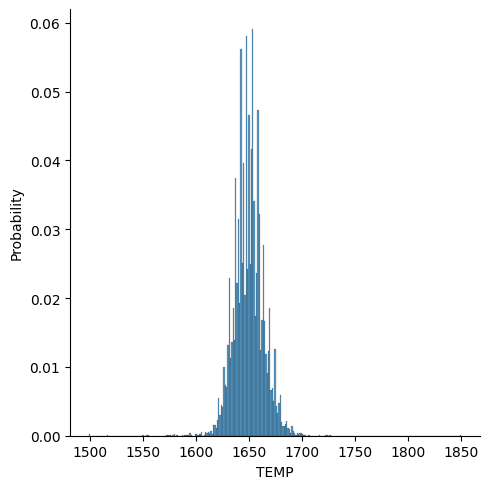

In [8]:
sns.displot(df4,x="TEMP",stat='probability')

Temperature seems to be more or less normally distributed. This also happens with most of the variables we will be using.

We look for outliers

In [9]:
def find_outliers_IQR(df,c):
    print(len(df))
    q1=df[c].quantile(0.25)
    q3=df[c].quantile(0.75)
    IQR=q3-q1
    print("IQR= (",q1-1.5*IQR,",",q3+1.5*IQR,")")
    outliers=df[c][((df[c]<(q1-1.5*IQR)) | (df[c]>(q3+1.5*IQR)) )]
    print(f"Number of outliers for {c}: {len(outliers)}")
    print(f"Max outlier: {outliers.max()}")
    print(f"Min outlier: {outliers.min()}")
    return outliers.index.tolist()

In [10]:
outlier_index=find_outliers_IQR(df4,"TEMP")

20827
IQR= ( 1615.5 , 1683.5 )
Number of outliers for TEMP: 354
Max outlier: 1850.0
Min outlier: 1499.0


Since the outliers are not very extreme, we could entertain doing a logarithmic transformation to keep them. However, we have very few of them, so for now we will just drop them. 

In [11]:
df5=df4.drop(outlier_index).reset_index()


We have succesfully processed the temperature values. Now let's see what we can do with the energy consumption table.

In [12]:
df_transf=pd.read_csv('eaf_transformer.csv', sep=',')

In [13]:
print(df_transf)

        TAP  HEATID            STARTTIME DURATION     MW
0        11  6F0020  2016-01-01 18:35:00   00: 29    0,5
1        17  6F0020  2016-01-01 19:04:00   10: 40     16
2        17  6F0020  2016-01-01 18:55:00   03: 00     11
3        17  6F0020  2016-01-01 18:37:00   13: 20  16,75
4        17  6F0020  2016-01-01 18:36:00   00: 40   0,75
...     ...     ...                  ...      ...    ...
271707   16  5F8442  2015-12-31 22:17:00   00: 10  0,125
271708   16  5F8442  2015-12-31 22:04:00   00: 10      0
271709   15  5F8442  2015-12-31 22:32:00   05: 30  8,125
271710   15  5F8442  2015-12-31 22:29:00   01: 31  2,125
271711   15  5F8442  2015-12-31 22:17:00   00: 10   0,25

[271712 rows x 5 columns]


Before doing feature engineering, we are going to try to make sure that we are not dealing with extreme, absurd values, specially in duration and MW. To do this analysis, we format both columns to make them usable. 

In [14]:
dfTc=df_transf.copy()

dfTc['MWF'] = df_transf['MW'].str.replace(',', '.').astype(float)

dfTc['DURATION_MINUTES'] = df_transf['DURATION'].str.split(':').apply(lambda x: int(x[0]) + int(x[1]) / 60)


In [15]:
out_MWF_ind=find_outliers_IQR(dfTc,"MWF")

271712
IQR= ( -4.625 , 8.375 )
Number of outliers for MWF: 47547
Max outlier: 999.999
Min outlier: -1049.624


We have negative outliers in our electricity values, let's explore this.

In [16]:
count_negatives = (dfTc['MWF'] < 0).sum()
print(count_negatives)
#ng_val = dfTc[dfTc['MWF'] < 0]['MWF']
#print(ng_val)

22


At least we have very few of them, so we assume they are mistakes and we can drop them.

In [17]:
indDrop = dfTc[dfTc['MWF'] < 0].index
dfTc2=dfTc.drop(indDrop)

Now we examine the positive outliers. 10 MW is an outlier according to the IQR, but since here we just want to remove very extreme, possibly faulty values, and not the high true values, we are going to address only values that are more than 50 MW, which is not normal and probably a mistake in the recordings.

In [18]:
count_posMis = (dfTc['MWF'] > 50).sum()
print(count_posMis)

5


Again, there are very few values, so we can drop.

In [19]:
indDrop2 = dfTc2[dfTc2['MWF'] < 0].index
dfTc3=dfTc2.drop(indDrop2)

This kind of processing will also be a constant along the project, paired sometimes with logarithmic or squared root transformations. We will not touch most of the outliers, since we feel they are relevant to the results. Maybe a more thorough outlier analysis could be performed for a fine optimization, but our models will have other more important problems.

We are going to have to do some feature engineering to be able to feed our information to an algorithm. Again, time series here might be useful in a more experienced and detailed analysis.

First we drop some unnecesary columns

In [20]:
print(dfTc3)

        TAP  HEATID            STARTTIME DURATION     MW     MWF  \
0        11  6F0020  2016-01-01 18:35:00   00: 29    0,5   0.500   
1        17  6F0020  2016-01-01 19:04:00   10: 40     16  16.000   
2        17  6F0020  2016-01-01 18:55:00   03: 00     11  11.000   
3        17  6F0020  2016-01-01 18:37:00   13: 20  16,75  16.750   
4        17  6F0020  2016-01-01 18:36:00   00: 40   0,75   0.750   
...     ...     ...                  ...      ...    ...     ...   
271707   16  5F8442  2015-12-31 22:17:00   00: 10  0,125   0.125   
271708   16  5F8442  2015-12-31 22:04:00   00: 10      0   0.000   
271709   15  5F8442  2015-12-31 22:32:00   05: 30  8,125   8.125   
271710   15  5F8442  2015-12-31 22:29:00   01: 31  2,125   2.125   
271711   15  5F8442  2015-12-31 22:17:00   00: 10   0,25   0.250   

        DURATION_MINUTES  
0               0.483333  
1              10.666667  
2               3.000000  
3              13.333333  
4               0.666667  
...                  

In [21]:
dfTc4=dfTc3.drop(["STARTTIME","DURATION","MW"],axis=1)

In [22]:
print(dfTc4)

        TAP  HEATID     MWF  DURATION_MINUTES
0        11  6F0020   0.500          0.483333
1        17  6F0020  16.000         10.666667
2        17  6F0020  11.000          3.000000
3        17  6F0020  16.750         13.333333
4        17  6F0020   0.750          0.666667
...     ...     ...     ...               ...
271707   16  5F8442   0.125          0.166667
271708   16  5F8442   0.000          0.166667
271709   15  5F8442   8.125          5.500000
271710   15  5F8442   2.125          1.516667
271711   15  5F8442   0.250          0.166667

[271690 rows x 4 columns]


In [23]:
print(dfTc3['TAP'].unique())

[11 17 16 13 15 14 12 18  7  8  9 10  6  4  5  2  1  3]


We will take into account the transformer stages later, but we are going to create first some easier and less noisy columns.

The first thing we are going to do is create a new dataframe that has the total energy spent per batch in megawatts per hour (MWh). We will calculate this by multiplying the electricity and time values.

In [24]:


df_T=pd.DataFrame()

df_T['MW_permin'] = dfTc4['MWF'] * dfTc4['DURATION_MINUTES']

df_T['HEATID']=dfTc4['HEATID']

dfT = df_T.groupby('HEATID', as_index=False)['MW_permin'].sum()

dfT['MWh'] = dfT['MW_permin'] / 60

dfT2=dfT.drop(["MW_permin"],axis=1)

print(dfT2)





       HEATID        MWh
0      5F0002   4.781944
1      5F0003  12.317708
2      5F0004   7.157986
3      5F0005  10.843160
4      5F0006  11.211806
...       ...        ...
20808  8F5226   8.573194
20809  8F5227   9.683472
20810  8F5471   4.566250
20811  8F5472   2.290833
20812  8F5473  15.257361

[20813 rows x 2 columns]


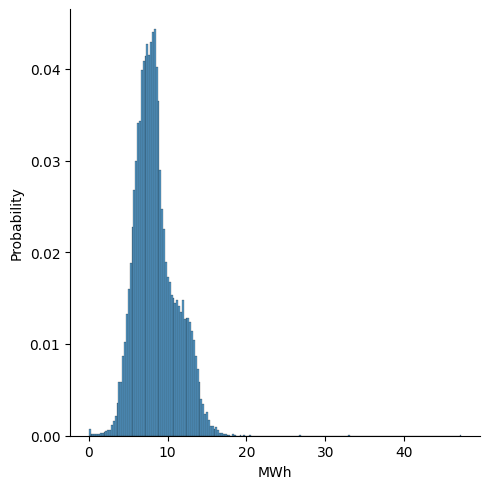

In [25]:
sns.displot(dfT2,x="MWh",stat="probability")

The values are more or less normally distributed, which is good. We look for outliers. Also, the spent energy seems to vary a lot more than the temperature, which might mean there is room for energy optimizing. 

In [26]:
out_MWh_ind=find_outliers_IQR(dfT2,"MWh")

20813
IQR= ( 1.8001388888888874 , 14.815694444444446 )
Number of outliers for MWh: 274
Max outlier: 47.222175
Min outlier: 0.008125


We do not have a lot of outliers, so we drop them

In [27]:
dfT3=dfT2.drop(out_MWh_ind)

We scale the column

In [28]:
from sklearn.preprocessing import MinMaxScaler
dfT4=dfT3.copy()

scaler1 = MinMaxScaler()

scaler1.fit(dfT3[["MWh"]])
dfT4.loc[:,"MWh"] = scaler1.transform(dfT3[["MWh"]])

In [29]:
print(dfT4)

       HEATID       MWh
0      5F0002  0.226436
1      5F0003  0.807465
2      5F0004  0.409636
3      5F0005  0.693773
4      5F0006  0.722197
...       ...       ...
20807  8F5223  0.583803
20808  8F5226  0.518752
20809  8F5227  0.604358
20810  8F5471  0.209805
20811  8F5472  0.034364

[20539 rows x 2 columns]


We are prepared now for a first benchmark test

In [30]:
dfMer = dfT4.merge(df5, on='HEATID', how='inner')

dfMer1= dfMer.drop(["index","HEATID"], axis=1)

print(dfMer1)

            MWh    TEMP
0      0.226436  1650.0
1      0.807465  1653.0
2      0.409636  1636.0
3      0.693773  1641.0
4      0.722197  1651.0
...         ...     ...
20193  0.583803  1648.0
20194  0.518752  1651.0
20195  0.604358  1648.0
20196  0.209805  1671.0
20197  0.034364  1661.0

[20198 rows x 2 columns]


In [31]:
dfMer1.corr()

,MWh,TEMP
MWh,1.000000,-0.172143
TEMP,-0.172143,1.000000


In [32]:
y1=dfMer1["TEMP"]
X1=dfMer1["MWh"]

This looks pretty bad. Apparently total consumption of energy was not as relevant as we thought. We will try a baseline model, however, to see how much we will improve later

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)

As a benchmark, we will use Linear Regression

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
import numpy as np

In [36]:
def rss_score(y, y_pred):
    return np.sum((y - y_pred)**2)

from math import sqrt
def my_performance_report(y_pred,y_test):
    mse_nn = mean_squared_error(y_test, y_pred)
    r2_nn = r2_score(y_test, y_pred)
    rss_nn=rss_score(y_test, y_pred)
    mae_nn=mean_absolute_error(y_test, y_pred)
    medae_nn=median_absolute_error(y_test, y_pred)
    evar_nn=explained_variance_score(y_test, y_pred)
    print("RSS:")
    print(rss_nn)
    print(f"MSE: {mse_nn:.2f}")
    print(f"RMSE: {sqrt(mse_nn):.2f}")
    print(f"Mean Absolute Error: {mae_nn:.2f}")
    print(f"Median Absolute Error: {medae_nn:.2f}")
    print(f"Explained Variance Score: {evar_nn:.2f}")
    print(f"R²: {r2_nn:.2f}")

In [37]:
X_train2 = X_train1.values.reshape(-1, 1)  # Convert to 2D so we can predict
X_test2 = X_test1.values.reshape(-1, 1)  

y_train2 = y_train1.squeeze()  #convert to series for the model also.
y_test2 = y_test1.squeeze()  

In [38]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train2, y_train2)

#yPredLin1 = lin_reg.predict(X_test1)

LinearRegression()

In [39]:
y_PredLin2= lin_reg.predict(X_test2)
my_performance_report(y_PredLin2,y_test2)

RSS:
614764.4715045821
MSE: 152.17
RMSE: 12.34
Mean Absolute Error: 9.86
Median Absolute Error: 8.13
Explained Variance Score: 0.03
R²: 0.03


As expected, we get very bad results, let's do some changes. 

In [40]:
print(dfTc4)

        TAP  HEATID     MWF  DURATION_MINUTES
0        11  6F0020   0.500          0.483333
1        17  6F0020  16.000         10.666667
2        17  6F0020  11.000          3.000000
3        17  6F0020  16.750         13.333333
4        17  6F0020   0.750          0.666667
...     ...     ...     ...               ...
271707   16  5F8442   0.125          0.166667
271708   16  5F8442   0.000          0.166667
271709   15  5F8442   8.125          5.500000
271710   15  5F8442   2.125          1.516667
271711   15  5F8442   0.250          0.166667

[271690 rows x 4 columns]


Now we will try to create meaningful variables to take into account energy consumption. 

We are going to add the number of times the transformer stage is changed

In [41]:
dfTc4['TAP_CHANGE'] = dfTc4['TAP'] != dfTc4.groupby('HEATID')['TAP'].shift()
tap_changes = dfTc4.groupby('HEATID')['TAP_CHANGE'].sum().reset_index()
tap_changes.rename(columns={'TAP_CHANGE': 'N_TF_CHANGES'}, inplace=True)

print(tap_changes)

       HEATID  N_TF_CHANGES
0      5F0002             5
1      5F0003             6
2      5F0004             7
3      5F0005             6
4      5F0006             5
...       ...           ...
20808  8F5226             7
20809  8F5227             7
20810  8F5471             7
20811  8F5472             4
20812  8F5473             3

[20813 rows x 2 columns]


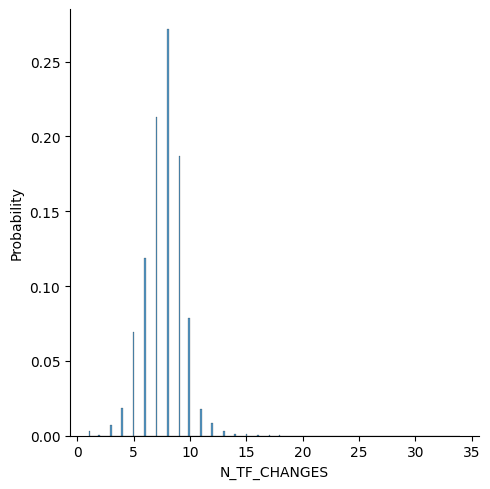

In [42]:
sns.displot(tap_changes,x="N_TF_CHANGES",stat="probability")

And also we are going to add the total time spent on melting the batch. 

In [43]:
total_duration = dfTc4.groupby('HEATID')['DURATION_MINUTES'].sum().reset_index()
total_duration.rename(columns={'DURATION_MINUTES': 'TOTAL_DURATION_MINUTES'}, inplace=True)
print(total_duration)

       HEATID  TOTAL_DURATION_MINUTES
0      5F0002               16.833333
1      5F0003               33.500000
2      5F0004               34.333333
3      5F0005               35.683333
4      5F0006               35.000000
...       ...                     ...
20808  8F5226               33.200000
20809  8F5227               35.016667
20810  8F5471               34.850000
20811  8F5472               11.116667
20812  8F5473               34.516667

[20813 rows x 2 columns]


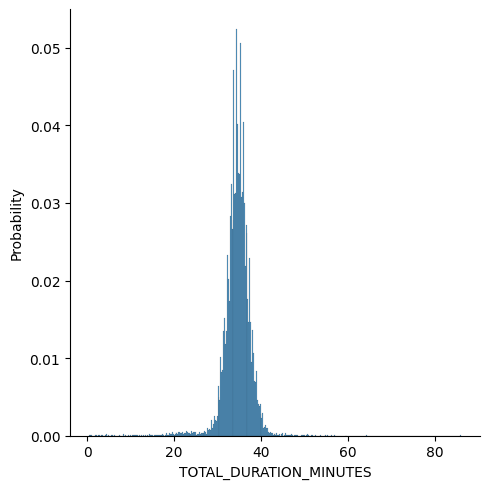

In [44]:
sns.displot(total_duration,x="TOTAL_DURATION_MINUTES",stat="probability")

We will process the outliers in these columns later

In [45]:
dfTrAddons = pd.merge(tap_changes, total_duration, on='HEATID')

print(dfTrAddons)


       HEATID  N_TF_CHANGES  TOTAL_DURATION_MINUTES
0      5F0002             5               16.833333
1      5F0003             6               33.500000
2      5F0004             7               34.333333
3      5F0005             6               35.683333
4      5F0006             5               35.000000
...       ...           ...                     ...
20808  8F5226             7               33.200000
20809  8F5227             7               35.016667
20810  8F5471             7               34.850000
20811  8F5472             4               11.116667
20812  8F5473             3               34.516667

[20813 rows x 3 columns]


We will also try to use later the average of electricity and time spent as an alternative to total energy spent.

In [46]:
total_mwf = dfTc4.groupby('HEATID')['MWF'].sum().reset_index()
total_mwf.rename(columns={'MWF': 'TOTAL_MWF'}, inplace=True)
print(total_mwf)

       HEATID  TOTAL_MWF
0      5F0002     48.625
1      5F0003     48.625
2      5F0004     47.375
3      5F0005     49.250
4      5F0006     49.875
...       ...        ...
20808  8F5226     49.500
20809  8F5227     51.250
20810  8F5471     49.500
20811  8F5472     48.750
20812  8F5473     49.750

[20813 rows x 2 columns]


In [47]:
dfAvg=pd.merge(total_mwf, total_duration, on='HEATID')

dfAvg['Avg'] = dfAvg['TOTAL_MWF'] * dfAvg['TOTAL_DURATION_MINUTES']


print(dfAvg)

       HEATID  TOTAL_MWF  TOTAL_DURATION_MINUTES          Avg
0      5F0002     48.625               16.833333   818.520833
1      5F0003     48.625               33.500000  1628.937500
2      5F0004     47.375               34.333333  1626.541667
3      5F0005     49.250               35.683333  1757.404167
4      5F0006     49.875               35.000000  1745.625000
...       ...        ...                     ...          ...
20808  8F5226     49.500               33.200000  1643.400000
20809  8F5227     51.250               35.016667  1794.604167
20810  8F5471     49.500               34.850000  1725.075000
20811  8F5472     48.750               11.116667   541.937500
20812  8F5473     49.750               34.516667  1717.204167

[20813 rows x 4 columns]


Another feature we will try to use is the energy consumed in each transformer stage, this way we are taking into account the power and time consumed in each TAP.

In [ ]:
dfTc4['MWh'] = dfTc4['MWF'] * dfTc4['DURATION_MINUTES'] / 60

energy_by_tap = dfTc4.pivot_table(
    index='HEATID', 
    columns='TAP', 
    values='MWh', 
    aggfunc='sum', 
    fill_value=0
)

energy_by_tap.columns = [f'MWh_TAP_{tap}' for tap in energy_by_tap.columns]

energy_by_tap.reset_index(inplace=True)

print(energy_by_tap)


       HEATID  MWh_TAP_1  MWh_TAP_2  MWh_TAP_3  MWh_TAP_4  MWh_TAP_5  \
0      5F0002        0.0        0.0        0.0        0.0        0.0   
1      5F0003        0.0        0.0        0.0        0.0        0.0   
2      5F0004        0.0        0.0        0.0        0.0        0.0   
3      5F0005        0.0        0.0        0.0        0.0        0.0   
4      5F0006        0.0        0.0        0.0        0.0        0.0   
...       ...        ...        ...        ...        ...        ...   
20808  8F5226        0.0        0.0        0.0        0.0        0.0   
20809  8F5227        0.0        0.0        0.0        0.0        0.0   
20810  8F5471        0.0        0.0        0.0        0.0        0.0   
20811  8F5472        0.0        0.0        0.0        0.0        0.0   
20812  8F5473        0.0        0.0        0.0        0.0        0.0   

       MWh_TAP_6  MWh_TAP_7  MWh_TAP_8  MWh_TAP_9  MWh_TAP_10  MWh_TAP_11  \
0            0.0        0.0        0.0        0.0         

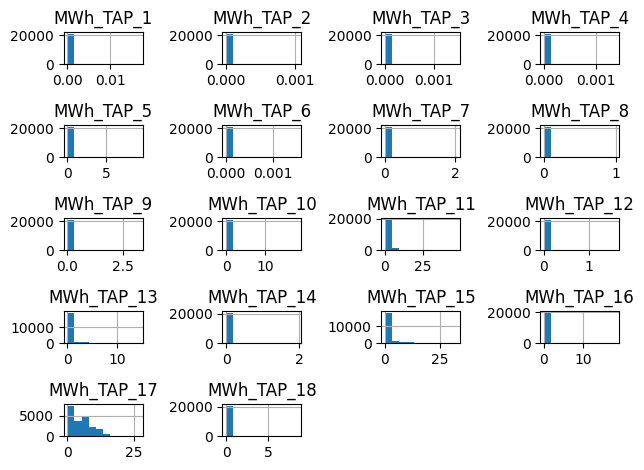

In [49]:
import matplotlib.pyplot as plt


histograms_energy=energy_by_tap.hist()
histograms_energy
plt.tight_layout()
plt.show()

These histograms do not give us a lot of hope on the created columns, since it seems like TAP 17 might have way more influence than the rest of columns. Maybe it is worth it to add another 17 columns with the time spent per TAP, we are going to prepare them in case we want to add them. 

In [ ]:

time_by_tap = dfTc4.pivot_table(
    index='HEATID', 
    columns='TAP', 
    values='DURATION_MINUTES', 
    aggfunc='sum', 
    fill_value=0
)

time_by_tap.columns = [f'TIME_TAP_{tap}' for tap in time_by_tap.columns]

time_by_tap.reset_index(inplace=True)

print(time_by_tap)

       HEATID  TIME_TAP_1  TIME_TAP_2  TIME_TAP_3  TIME_TAP_4  TIME_TAP_5  \
0      5F0002         0.0         0.0         0.0         0.0         0.0   
1      5F0003         0.0         0.0         0.0         0.0         0.0   
2      5F0004         0.0         0.0         0.0         0.0         0.0   
3      5F0005         0.0         0.0         0.0         0.0         0.0   
4      5F0006         0.0         0.0         0.0         0.0         0.0   
...       ...         ...         ...         ...         ...         ...   
20808  8F5226         0.0         0.0         0.0         0.0         0.0   
20809  8F5227         0.0         0.0         0.0         0.0         0.0   
20810  8F5471         0.0         0.0         0.0         0.0         0.0   
20811  8F5472         0.0         0.0         0.0         0.0         0.0   
20812  8F5473         0.0         0.0         0.0         0.0         0.0   

       TIME_TAP_6  TIME_TAP_7  TIME_TAP_8  TIME_TAP_9  TIME_TAP_10  \
0    

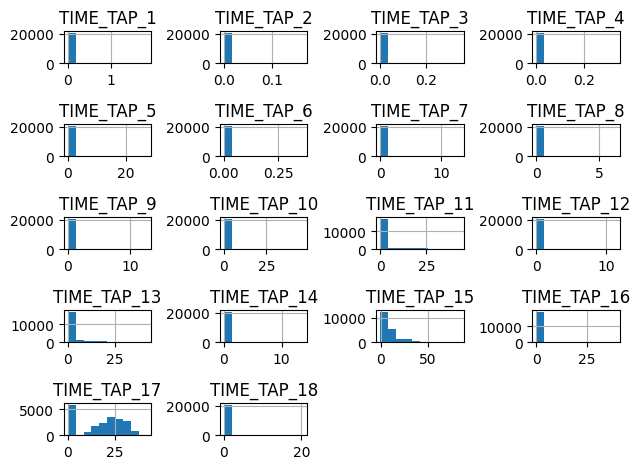

In [51]:
import matplotlib.pyplot as plt


histograms_time=time_by_tap.hist()
histograms_time
plt.tight_layout()
plt.show()

We will try using them together and separatedly.

In [52]:
# this dataframe has energy for tap but not time for tap
dfTrAddons2 = pd.merge(dfTrAddons, energy_by_tap, on='HEATID')


In [53]:
# this dataframe has BOTH energy for tap and time for tap
dfTrAddons3 = pd.merge(dfTrAddons2, time_by_tap, on='HEATID')



In [54]:
# this dataframe does not have energy for tap but has time for tap
dfTrAddons4 = pd.merge(dfTrAddons, time_by_tap, on='HEATID')



For now we are just going to add the first two columns we intended in the first place. 

In [55]:
dfMer2 = dfMer.merge(dfTrAddons, on='HEATID', how='inner')


print(dfMer2)

       HEATID       MWh  index    TEMP  N_TF_CHANGES  TOTAL_DURATION_MINUTES
0      5F0002  0.226436      0  1650.0             5               16.833333
1      5F0003  0.807465      1  1653.0             6               33.500000
2      5F0004  0.409636      2  1636.0             7               34.333333
3      5F0005  0.693773      3  1641.0             6               35.683333
4      5F0006  0.722197      4  1651.0             5               35.000000
...       ...       ...    ...     ...           ...                     ...
20193  8F5223  0.583803  20820  1648.0             7               35.966667
20194  8F5226  0.518752  20821  1651.0             7               33.200000
20195  8F5227  0.604358  20822  1648.0             7               35.016667
20196  8F5471  0.209805  20824  1671.0             7               34.850000
20197  8F5472  0.034364  20825  1661.0             4               11.116667

[20198 rows x 6 columns]


In [56]:
dfMer3=dfMer2.drop(["index"],axis=1)

We look at the outliers in the added columns. 

In [57]:
outliersNumchanges=find_outliers_IQR(dfMer3,"N_TF_CHANGES")

20198
IQR= ( 4.0 , 12.0 )
Number of outliers for N_TF_CHANGES: 320
Max outlier: 34
Min outlier: 1


In [58]:
outliersTotalDuration=find_outliers_IQR(dfMer3,"TOTAL_DURATION_MINUTES")

20198
IQR= ( 28.75000000000001 , 40.61666666666666 )
Number of outliers for TOTAL_DURATION_MINUTES: 674
Max outlier: 86.16666666666667
Min outlier: 2.183333333333333


Since we do not have a lot of outliers, we will drop them. We might come back to them later. 

In [ ]:
index_drop = list(set(outliersTotalDuration + outliersNumchanges)) 

df2ndTry=dfMer3.drop(index_drop) 

print(df2ndTry)

       HEATID       MWh    TEMP  N_TF_CHANGES  TOTAL_DURATION_MINUTES
1      5F0003  0.807465  1653.0             6               33.500000
2      5F0004  0.409636  1636.0             7               34.333333
3      5F0005  0.693773  1641.0             6               35.683333
4      5F0006  0.722197  1651.0             5               35.000000
5      5F0007  0.742811  1649.0             7               33.333333
...       ...       ...     ...           ...                     ...
20192  8F5221  0.358560  1645.0             7               37.200000
20193  8F5223  0.583803  1648.0             7               35.966667
20194  8F5226  0.518752  1651.0             7               33.200000
20195  8F5227  0.604358  1648.0             7               35.016667
20196  8F5471  0.209805  1671.0             7               34.850000

[19237 rows x 5 columns]


In [60]:
scaler = MinMaxScaler()

dfMod2ndTry=df2ndTry.drop("HEATID",axis=1)


In [61]:
dfMod2ndTry[['N_TF_CHANGES', 'TOTAL_DURATION_MINUTES']] = scaler.fit_transform(dfMod2ndTry[['N_TF_CHANGES', 'TOTAL_DURATION_MINUTES']])

print(dfMod2ndTry)

            MWh    TEMP  N_TF_CHANGES  TOTAL_DURATION_MINUTES
1      0.807465  1653.0         0.250                0.401697
2      0.409636  1636.0         0.375                0.472419
3      0.693773  1641.0         0.250                0.586987
4      0.722197  1651.0         0.125                0.528996
5      0.742811  1649.0         0.375                0.387553
...         ...     ...           ...                     ...
20192  0.358560  1645.0         0.375                0.715700
20193  0.583803  1648.0         0.375                0.611033
20194  0.518752  1651.0         0.375                0.376238
20195  0.604358  1648.0         0.375                0.530410
20196  0.209805  1671.0         0.375                0.516266

[19237 rows x 4 columns]


In [62]:
dfMod2ndTry.corr()

,MWh,TEMP,N_TF_CHANGES,TOTAL_DURATION_MINUTES
MWh,1.000000,-0.175384,-0.175678,0.218828
TEMP,-0.175384,1.000000,-0.032977,-0.011938
N_TF_CHANGES,-0.175678,-0.032977,1.000000,0.001486
TOTAL_DURATION_MINUTES,0.218828,-0.011938,0.001486,1.000000


The columns we added do not seem to provide a lot of value. Let's test it.

In [63]:
X2try=dfMod2ndTry.drop("TEMP",axis=1)
y2try=dfMod2ndTry["TEMP"]

In [64]:
from sklearn.model_selection import train_test_split
X_train2try, X_test2try, y_train2try, y_test2try = train_test_split(X2try, y2try, test_size=0.2)
from sklearn.linear_model import LinearRegression
lReg2try = LinearRegression()
lReg2try.fit(X_train2try, y_train2try)


LinearRegression()

In [65]:
y_PredLin2try= lReg2try.predict(X_test2try)
my_performance_report(y_PredLin2try,y_test2try)

RSS:
565380.2820430205
MSE: 146.93
RMSE: 12.12
Mean Absolute Error: 9.66
Median Absolute Error: 8.07
Explained Variance Score: 0.04
R²: 0.04


It looks like our engineered columns are not effective at all. This might be caused by our lack of expertise in the field, or by a lack of relationship between energy usage and temperature.

We will try now adding the 17 energy per tap values. If that does not work, we might need to change the approach of the project.

In [66]:
dfTrAddons3rd=dfTrAddons3.drop(['N_TF_CHANGES', 'TOTAL_DURATION_MINUTES'],axis=1)

In [67]:
df3rdTry = df2ndTry.merge(dfTrAddons3rd, on='HEATID', how='inner')

In [68]:
print(df3rdTry)

       HEATID       MWh    TEMP  N_TF_CHANGES  TOTAL_DURATION_MINUTES  \
0      5F0003  0.807465  1653.0             6               33.500000   
1      5F0004  0.409636  1636.0             7               34.333333   
2      5F0005  0.693773  1641.0             6               35.683333   
3      5F0006  0.722197  1651.0             5               35.000000   
4      5F0007  0.742811  1649.0             7               33.333333   
...       ...       ...     ...           ...                     ...   
19232  8F5221  0.358560  1645.0             7               37.200000   
19233  8F5223  0.583803  1648.0             7               35.966667   
19234  8F5226  0.518752  1651.0             7               33.200000   
19235  8F5227  0.604358  1648.0             7               35.016667   
19236  8F5471  0.209805  1671.0             7               34.850000   

       MWh_TAP_1  MWh_TAP_2  MWh_TAP_3  MWh_TAP_4  MWh_TAP_5  ...  TIME_TAP_9  \
0            0.0        0.0        0.0    

In [69]:
scaler3rd = MinMaxScaler()

df3rdTryS=df3rdTry.copy()

# Select only the numerical columns
numerical_cols = df3rdTry.select_dtypes(include=['number']).columns

# Apply MinMaxScaler to the numerical columns
df3rdTryS[numerical_cols] = scaler3rd.fit_transform(df3rdTry[numerical_cols])

#maybe scaling is not such a good idea here, because o.1 in tap 1 counts the same as 15 in tap 17

In [70]:
print(df3rdTryS)

       HEATID       MWh      TEMP  N_TF_CHANGES  TOTAL_DURATION_MINUTES  \
0      5F0003  0.797225  0.552239         0.250                0.401697   
1      5F0004  0.378237  0.298507         0.375                0.472419   
2      5F0005  0.677486  0.373134         0.250                0.586987   
3      5F0006  0.707422  0.522388         0.125                0.528996   
4      5F0007  0.729132  0.492537         0.375                0.387553   
...       ...       ...       ...           ...                     ...   
19232  8F5221  0.324445  0.432836         0.375                0.715700   
19233  8F5223  0.561667  0.477612         0.375                0.611033   
19234  8F5226  0.493157  0.522388         0.375                0.376238   
19235  8F5227  0.583315  0.477612         0.375                0.530410   
19236  8F5471  0.167779  0.820896         0.375                0.516266   

       MWh_TAP_1  MWh_TAP_2  MWh_TAP_3  MWh_TAP_4  MWh_TAP_5  ...  TIME_TAP_9  \
0            0.0  

In [71]:
X3try=dfMod2ndTry.drop("TEMP",axis=1)
y3try=dfMod2ndTry["TEMP"]

from sklearn.model_selection import train_test_split
X_train3try, X_test3try, y_train3try, y_test3try = train_test_split(X3try, y3try, test_size=0.2)
from sklearn.linear_model import LinearRegression
lReg3try = LinearRegression()
lReg3try.fit(X_train3try, y_train3try)

LinearRegression()

In [72]:
y_PredLin3try= lReg3try.predict(X_test3try)
my_performance_report(y_PredLin3try,y_test3try)

RSS:
571284.4409016593
MSE: 148.46
RMSE: 12.18
Mean Absolute Error: 9.75
Median Absolute Error: 8.23
Explained Variance Score: 0.04
R²: 0.04


Adding our columns does not provide any benefit, it seems.

Let's see if adding material composition would report us any results

In [73]:
df_chem=pd.read_csv('lf_initial_chemical_measurements.csv', sep=',')

In [74]:
print(df_chem)

       HEATID  POSITIONROW             DATETIME    VALC   VALSI   VALMN  \
0      6F0020            1  2016-01-01 19:59:00  0,2312  0,2449  1,2652   
1      6F0021            1  2016-01-01 20:59:00  0,2507  0,2687  1,2916   
2      6F0022            1  2016-01-01 21:53:00   0,234  0,2276  1,1963   
3      6F0023            1  2016-01-01 23:27:00  0,3652  0,2154  0,7934   
4      6F0024            1  2016-01-02 00:32:00   0,374  0,1932  0,7948   
...       ...          ...                  ...     ...     ...     ...   
20822  5F8438            1  2015-12-31 20:09:00  0,1713  0,1593  0,4194   
20823  5F8439            1  2015-12-31 20:38:00  0,1812  0,1928  0,3834   
20824  5F8440            1  2015-12-31 21:29:00  0,1752  0,2399  0,3864   
20825  5F8441            1  2015-12-31 22:20:00  0,1736   0,218  0,3644   
20826  5F8442            1  2015-12-31 23:04:00  0,1828   0,232  0,4115   

         VALP    VALS   VALCU   VALCR   VALMO   VALNI  
0      0,0076  0,0147  0,2072  0,0726  0,01

In [75]:
df_chem.drop_duplicates(inplace=True)
print(df_chem.isnull().sum())

HEATID         0
POSITIONROW    0
DATETIME       0
VALC           0
VALSI          0
VALMN          0
VALP           0
VALS           0
VALCU          0
VALCR          0
VALMO          0
VALNI          0
dtype: int64


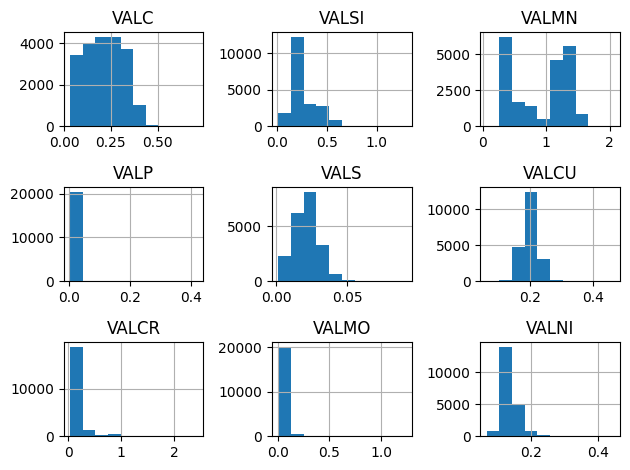

In [76]:
df_chem2 = df_chem.drop(columns=['DATETIME', 'POSITIONROW'])

df_chem3 = df_chem2.apply(lambda col: col.str.replace(",", ".").astype(float) 
                          if col.name != "HEATID" and col.dtypes == "object" else col)
histograms=df_chem3.hist()
histograms
plt.tight_layout()
plt.show()

In [77]:
dfTEMP = df_chem3.merge(df5, on='HEATID', how='inner')
dfTEMP1=dfTEMP.drop(["HEATID","index"],axis=1)
dfTEMP1.corr()

,VALC,VALSI,VALMN,VALP,VALS,VALCU,VALCR,VALMO,VALNI,TEMP
VALC,1.000000,-0.037305,0.346248,0.051569,0.180886,0.025428,-0.141316,-0.066047,0.006276,0.020134
VALSI,-0.037305,1.000000,0.561971,0.019893,-0.097227,0.015756,0.001292,0.049651,0.038146,0.039450
VALMN,0.346248,0.561971,1.000000,0.035603,0.067150,0.048465,-0.241042,-0.019392,0.054349,0.061784
VALP,0.051569,0.019893,0.035603,1.000000,-0.006350,0.027072,-0.010391,0.609139,-0.059904,0.045137
VALS,0.180886,-0.097227,0.067150,-0.006350,1.000000,0.178406,-0.218369,-0.072034,0.106926,-0.022840
VALCU,0.025428,0.015756,0.048465,0.027072,0.178406,1.000000,-0.143216,-0.068121,0.313165,-0.076994
VALCR,-0.141316,0.001292,-0.241042,-0.010391,-0.218369,-0.143216,1.000000,0.282774,-0.015109,0.071333
VALMO,-0.066047,0.049651,-0.019392,0.609139,-0.072034,-0.068121,0.282774,1.000000,-0.010773,0.065897
VALNI,0.006276,0.038146,0.054349,-0.059904,0.106926,0.313165,-0.015109,-0.010773,1.000000,-0.028713
TEMP,0.020134,0.039450,0.061784,0.045137,-0.022840,-0.076994,0.071333,0.065897,-0.028713,1.000000


It seems like it is going to be very difficult to relate energy consumption with final temperature, even if we added material composition as a predictor. This, however, is a valuable piece of information, since it tells us that the problems we might have in our process are not really related to temperature. It seems as if the energy consumption just adapts to what the metal needs each time to get to the optimal temperature. What we would like to do then is to find the optimal parameters of a process so that we consume the least energy. 

What we are going to do then is to try to predict energy based on other parameters, such as material composition, gas flow, etc.

In [78]:
dfBase = df_chem3.merge(dfT2, on='HEATID', how='inner')

In [79]:
print(dfBase)

       HEATID    VALC   VALSI   VALMN    VALP    VALS   VALCU   VALCR   VALMO  \
0      6F0020  0.2312  0.2449  1.2652  0.0076  0.0147  0.2072  0.0726  0.0194   
1      6F0021  0.2507  0.2687  1.2916  0.0055  0.0204  0.2045  0.0747  0.0206   
2      6F0022  0.2340  0.2276  1.1963  0.0056  0.0193  0.1898  0.0695  0.0203   
3      6F0023  0.3652  0.2154  0.7934  0.0078  0.0250  0.2154  0.0956  0.0342   
4      6F0024  0.3740  0.1932  0.7948  0.0071  0.0202  0.2191  0.1029  0.0267   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
20808  5F8438  0.1713  0.1593  0.4194  0.0064  0.0246  0.1921  0.1189  0.0382   
20809  5F8439  0.1812  0.1928  0.3834  0.0065  0.0196  0.1859  0.0853  0.0253   
20810  5F8440  0.1752  0.2399  0.3864  0.0065  0.0129  0.1605  0.0773  0.0117   
20811  5F8441  0.1736  0.2180  0.3644  0.0061  0.0176  0.1827  0.0772  0.0159   
20812  5F8442  0.1828  0.2320  0.4115  0.0064  0.0147  0.1916  0.0772  0.0138   

        VALNI        MWh  


In [80]:
dfBase1=dfBase.drop(["HEATID"],axis=1)

In [81]:
YChem=dfBase1["MWh"]
XChem=dfBase1.drop(["MWh"],axis=1)

In [82]:
outliers_indices = []

for column in XChem.columns:
    q1 = XChem[column].quantile(0.25)
    q3 = XChem[column].quantile(0.75)
    IQR = q3 - q1
    print(f"IQR for column {column}: {IQR} {(q1 - 1.5 * IQR, q3 + 1.5 * IQR)}")
    
    outliers = XChem[column][((XChem[column] < (q1 - 1.5 * IQR)) | (XChem[column] > (q3 + 1.5 * IQR)))]
    
    outliers_indices.extend(outliers.index)
    
    print(f"Number of outliers for {column}: {len(outliers)}")
    print(f"Max outlier for {column}: {outliers.max()}")
    print(f"Min outlier for {column}: {outliers.min()}")
    #print(outliers)

outliers_indices = list(set(outliers_indices))

print(f"Total unique outliers: {len(outliers_indices)}")

IQR for column VALC: 0.15449999999999997 (np.float64(-0.08864999999999995), np.float64(0.52935))
Number of outliers for VALC: 4
Max outlier for VALC: 0.7114
Min outlier for VALC: 0.5476
IQR for column VALSI: 0.15040000000000003 (np.float64(-0.04510000000000006), np.float64(0.5565000000000001))
Number of outliers for VALSI: 555
Max outlier for VALSI: 1.2883
Min outlier for VALSI: 0.5566
IQR for column VALMN: 0.8616999999999999 (np.float64(-0.8616499999999998), np.float64(2.5851499999999996))
Number of outliers for VALMN: 0
Max outlier for VALMN: nan
Min outlier for VALMN: nan
IQR for column VALP: 0.0026999999999999993 (np.float64(0.002850000000000001), np.float64(0.013649999999999999))
Number of outliers for VALP: 960
Max outlier for VALP: 0.42
Min outlier for VALP: 0.0024
IQR for column VALS: 0.011600000000000001 (np.float64(-0.002100000000000003), np.float64(0.044300000000000006))
Number of outliers for VALS: 176
Max outlier for VALS: 0.0909
Min outlier for VALS: 0.0444
IQR for column

There are a lot of outliers here. Maybe a logarithmic transformation of the data would be advisable.

In [83]:
#XChemD=XChem.drop(outliers_indices)
#YChemD=YChem.drop(outliers_indices)

#dropping the outliers was not effective because of a loss of information, that is why this line is commented.

In [84]:
XChemL=XChem.apply(np.log)

In [85]:
#we tried a scaler but it did not really improve our results

#scaler = MinMaxScaler()

#XChem = pd.DataFrame(scaler.fit_transform(XChem1), columns=XChem1.columns, index=XChem1.index)

Let's see if the number of outliers is more manageable now.

In [86]:
outliers_indices = []

for column in XChemL.columns:
    q1 = XChemL[column].quantile(0.25)
    q3 = XChemL[column].quantile(0.75)
    IQR = q3 - q1
    print(f"IQR for column {column}: {IQR} {(q1 - 1.5 * IQR, q3 + 1.5 * IQR)}")
    
    outliers = XChemL[column][((XChemL[column] < (q1 - 1.5 * IQR)) | (XChemL[column] > (q3 + 1.5 * IQR)))]
    
    outliers_indices.extend(outliers.index)
    
    print(f"Number of outliers for {column}: {len(outliers)}")
    print(f"Max outlier for {column}: {outliers.max()}")
    print(f"Min outlier for {column}: {outliers.min()}")
    #print(outliers)

outliers_indices = list(set(outliers_indices))

print(f"Total unique outliers: {len(outliers_indices)}")

IQR for column VALC: 0.7322066163965315 (np.float64(-3.0425215170145288), np.float64(-0.1136950514284032))
Number of outliers for VALC: 35
Max outlier for VALC: -3.0449225177447627
Min outlier for VALC: -3.4769990950784373
IQR for column VALSI: 0.6060854371546309 (np.float64(-2.621152656941148), np.float64(-0.19681090832262416))
Number of outliers for VALSI: 353
Max outlier for VALSI: 0.253323519815342
Min outlier for VALSI: -4.261580481598014
IQR for column VALMN: 1.0985349282070027 (np.float64(-2.4896816266708486), np.float64(1.904458086157162))
Number of outliers for VALMN: 2
Max outlier for VALMN: -2.622790357151387
Min outlier for VALMN: -2.766209115275742
IQR for column VALP: 0.3302416868705764 (np.float64(-5.471596397684788), np.float64(-4.150629650202482))
Number of outliers for VALP: 685
Max outlier for VALP: -0.8675005677047231
Min outlier for VALP: -6.032286541628237
IQR for column VALS: 0.5642734582094038 (np.float64(-5.026312637897853), np.float64(-2.769218805060238))
Numb

We might need to process the outliers a bit further. This was not possible due to a lack of time, but it would be advisable in a deeper analysis.

In [90]:
dfBase1.corr()

,VALC,VALSI,VALMN,VALP,VALS,VALCU,VALCR,VALMO,VALNI,MWh
VALC,1.000000,-0.034734,0.348599,0.052546,0.181105,0.024826,-0.143464,-0.066438,0.004909,0.124438
VALSI,-0.034734,1.000000,0.562426,0.020215,-0.096935,0.014510,-0.000480,0.049860,0.038208,-0.028436
VALMN,0.348599,0.562426,1.000000,0.034985,0.068014,0.046852,-0.243262,-0.020824,0.053286,0.011140
VALP,0.052546,0.020215,0.034985,1.000000,-0.007555,0.028465,-0.009435,0.609248,-0.062016,0.176129
VALS,0.181105,-0.096935,0.068014,-0.007555,1.000000,0.177820,-0.221014,-0.073677,0.107362,0.007077
VALCU,0.024826,0.014510,0.046852,0.028465,0.177820,1.000000,-0.142888,-0.067170,0.314117,0.056620
VALCR,-0.143464,-0.000480,-0.243262,-0.009435,-0.221014,-0.142888,1.000000,0.285866,-0.015309,-0.102256
VALMO,-0.066438,0.049860,-0.020824,0.609248,-0.073677,-0.067170,0.285866,1.000000,-0.013599,0.079023
VALNI,0.004909,0.038208,0.053286,-0.062016,0.107362,0.314117,-0.015309,-0.013599,1.000000,-0.029681
MWh,0.124438,-0.028436,0.011140,0.176129,0.007077,0.056620,-0.102256,0.079023,-0.029681,1.000000


The relationships between the variables are a bit better than before. Still, this is going to be a hard problem to solve. 

In [91]:
from sklearn.model_selection import train_test_split
XTrainCh, XTestCh, yTrainCh, yTestCh = train_test_split(XChemL, YChem, test_size=0.2)
from sklearn.linear_model import LinearRegression
lReg1Chem = LinearRegression()
lReg1Chem.fit(XTrainCh, yTrainCh)

yPredLCh= lReg1Chem.predict(XTestCh)
my_performance_report(yPredLCh,yTestCh)

RSS:
25764.688023005965
MSE: 6.19
RMSE: 2.49
Mean Absolute Error: 1.96
Median Absolute Error: 1.64
Explained Variance Score: 0.06
R²: 0.06


Again, results are slightly better

We are going to take into account the mass of metal charged in the furnace. 

In [92]:
dfCharged=pd.read_csv('basket_charged.csv', sep=',')

print(dfCharged)

        MAT_CODE                 MAT_DEC  HEATID             DATETIME  \
0         205051                      3A  6F0020  2016-01-01 18:51:00   
1         205051                      3A  6F0020  2016-01-01 19:24:00   
2         360258  In-house produced lime  6F0020  2016-01-01 18:33:00   
3         205051                      3A  6F0020  2016-01-01 18:51:00   
4         360258  In-house produced lime  6F0020  2016-01-01 18:51:00   
...          ...                     ...     ...                  ...   
137680    201010        Steelmaking iron  5F8442  2015-12-31 22:14:00   
137681    205051                      3A  5F8442  2015-12-31 22:14:00   
137682    360258  In-house produced lime  5F8442  2015-12-31 22:14:00   
137683    360258  In-house produced lime  5F8442  2015-12-31 22:01:00   
137684    205051                      3A  5F8442  2015-12-31 22:01:00   

       CHARGED_AMOUNT  
0               54071  
1               75240  
2                2502  
3                4773  
4  

C:\Users\quinito\AppData\Local\Temp\ipykernel_17136\3390344670.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  dfCharged=pd.read_csv('basket_charged.csv', sep=',')


In [93]:
dfCharged.dtypes

MAT_CODE           int64
MAT_DEC           object
HEATID            object
DATETIME          object
CHARGED_AMOUNT    object
dtype: object

In [94]:
dfCharged1=dfCharged.copy()
dfCharged1['CHARGED_AMOUNT'] = pd.to_numeric(dfCharged['CHARGED_AMOUNT'], errors='coerce').fillna(0).astype(int)

In [ ]:
totalKg = dfCharged1.groupby('HEATID')['CHARGED_AMOUNT'].sum().reset_index()

totalKg.columns = ['HEATID', 'TOTAL_CHARGED_AMOUNT']

print(totalKg)

       HEATID  TOTAL_CHARGED_AMOUNT
0      5F0002                128590
1      5F0003                128826
2      5F0004                133715
3      5F0005                129233
4      5F0006                132505
...       ...                   ...
20801  8F5226                128886
20802  8F5227                128737
20803  8F5471                124999
20804  8F5472                128222
20805  8F5473                128664

[20806 rows x 2 columns]


In [96]:
dfLast = totalKg.merge(dfT3, on='HEATID', how='inner')

In [97]:
dfLast1=dfLast.drop(["HEATID"],axis=1)

print(dfLast1)

       TOTAL_CHARGED_AMOUNT        MWh
0                    128590   4.781944
1                    128826  12.317708
2                    133715   7.157986
3                    129233  10.843160
4                    132505  11.211806
...                     ...        ...
20529                133157   9.416875
20530                128886   8.573194
20531                128737   9.683472
20532                124999   4.566250
20533                128222   2.290833

[20534 rows x 2 columns]


In [98]:
dfLast1.corr()

,TOTAL_CHARGED_AMOUNT,MWh
TOTAL_CHARGED_AMOUNT,1.000000,0.159959
MWh,0.159959,1.000000


Correlation is pretty weak, but not that bad. We are also going to try to do a little bit better of an engineering on the target variable, taking more into account time, so instead of doing power * time, we will do avg power * avg time. This way maybe the values will be more predictable and similar.

In [99]:
dfHope=totalKg.merge(dfAvg, on='HEATID', how='inner')

In [100]:
dfHopeMore=dfHope.merge(dfBase, on='HEATID', how='inner')

In [101]:
print(dfHopeMore)

       HEATID  TOTAL_CHARGED_AMOUNT  TOTAL_MWF  TOTAL_DURATION_MINUTES  \
0      5F0002                128590     48.625               16.833333   
1      5F0003                128826     48.625               33.500000   
2      5F0004                133715     47.375               34.333333   
3      5F0005                129233     49.250               35.683333   
4      5F0006                132505     49.875               35.000000   
...       ...                   ...        ...                     ...   
20791  8F5226                128886     49.500               33.200000   
20792  8F5227                128737     51.250               35.016667   
20793  8F5471                124999     49.500               34.850000   
20794  8F5472                128222     48.750               11.116667   
20795  8F5473                128664     49.750               34.516667   

               Avg    VALC   VALSI   VALMN    VALP    VALS   VALCU   VALCR  \
0       818.520833  0.1457  0.276

In [102]:
Finaldf=dfHopeMore.drop(["HEATID","TOTAL_MWF","TOTAL_DURATION_MINUTES"],axis=1)

In [103]:
matrix=Finaldf.corr()
result = matrix.loc[["MWh","Avg"]]

print(result)

     TOTAL_CHARGED_AMOUNT      Avg      VALC     VALSI     VALMN      VALP  \
MWh              0.164212  0.27376  0.123702 -0.029287  0.010509  0.176487   
Avg              0.082988  1.00000  0.183296 -0.067148  0.042831  0.006402   

         VALS    VALCU     VALCR     VALMO     VALNI      MWh  
MWh  0.006808  0.05759 -0.102263  0.079136 -0.028749  1.00000  
Avg  0.127088 -0.00602 -0.093582 -0.033448  0.053723  0.27376  


it does not look like the correlations are going to be significantly better, so we will not take into account the new engineered column.

In [104]:
Finaldf1=Finaldf.drop(["Avg"],axis=1)

In [105]:
YFin=Finaldf1["MWh"]
XFin=Finaldf1.drop(["MWh"],axis=1)
from sklearn.model_selection import train_test_split
XTrainFin, XTestFin, yTrainFin, yTestFin = train_test_split(XFin, YFin, test_size=0.2)
from sklearn.linear_model import LinearRegression
lReg1Fin = LinearRegression()
lReg1Fin.fit(XTrainFin, yTrainFin)

yPredLFin= lReg1Fin.predict(XTestFin)
my_performance_report(yPredLFin,yTestFin)

RSS:
25464.23735505415
MSE: 6.12
RMSE: 2.47
Mean Absolute Error: 1.95
Median Absolute Error: 1.66
Explained Variance Score: 0.08
R²: 0.08


Again, we make slow but constant progress.

In [106]:
from xgboost import XGBRegressor
xgbF = XGBRegressor(n_estimators=100).fit(XTrainFin, yTrainFin)
yPredXFin= xgbF.predict(XTestFin)
my_performance_report(yPredXFin,yTestFin)

RSS:
24438.04753751772
MSE: 5.87
RMSE: 2.42
Mean Absolute Error: 1.89
Median Absolute Error: 1.54
Explained Variance Score: 0.11
R²: 0.11


In [107]:
print(XTestFin)

       TOTAL_CHARGED_AMOUNT    VALC   VALSI   VALMN    VALP    VALS   VALCU  \
6910                 120594  0.1167  0.1892  0.4568  0.0054  0.0043  0.2024   
10020                140246  0.1594  0.0978  0.4146  0.0085  0.0291  0.1990   
7937                 128544  0.0681  0.5833  1.2197  0.0063  0.0149  0.2371   
3103                 126220  0.1754  0.2005  0.4213  0.0088  0.0222  0.1334   
10045                134696  0.1248  0.2287  0.5039  0.0103  0.0195  0.1739   
...                     ...     ...     ...     ...     ...     ...     ...   
18970                134772  0.3434  0.4466  1.2717  0.0144  0.0222  0.2079   
14126                139142  0.3169  0.3902  1.3592  0.0078  0.0286  0.2350   
19110                133228  0.2984  0.3951  1.1128  0.0124  0.0200  0.2064   
3479                 141272  0.3211  0.3377  1.4081  0.0082  0.0140  0.2327   
14127                139759  0.3376  0.4325  1.4441  0.0077  0.0269  0.2314   

        VALCR   VALMO   VALNI  
6910   0.4259  0.01

We also add gas usage.

In [108]:
dfGas=pd.read_csv('eaf_gaslance_mat.csv', sep=',')

print(dfGas)


                         REVTIME O2_AMOUNT GAS_AMOUNT   O2_FLOW GAS_FLOW  \
0        2016-01-01 18:31:46,003      0,00       0,00     0,000    0,000   
1        2016-01-01 18:31:55,925   4555,00     548,00     0,000    0,000   
2        2016-01-01 18:32:55,972      0,00       0,00     0,000    0,000   
3        2016-01-01 18:33:05,956      0,00       0,00  2628,000    0,000   
4        2016-01-01 18:33:16,019      1,00       0,00  1077,000  164,000   
...                          ...       ...        ...       ...      ...   
5748189  2015-12-31 22:40:26,420   3888,00     537,00     0,000    0,000   
5748190  2015-12-31 22:40:36,654   3893,00     537,00     0,000    0,000   
5748191  2015-12-31 22:40:46,513   3898,00     537,00  1817,000   83,000   
5748192  2015-12-31 22:40:56,482   3903,00     537,00  1971,000   84,000   
5748193  2015-12-31 22:43:26,498   3907,00     538,00     0,000    0,000   

         HEATID  
0        6F0020  
1        6F0020  
2        6F0020  
3        6F0020

We get the most representative value of gas usage for each heatID

In [109]:
dfGasLast = dfGas.groupby('HEATID')[['GAS_AMOUNT', 'O2_AMOUNT']].last().reset_index()

In [110]:
print(dfGasLast)

       HEATID GAS_AMOUNT O2_AMOUNT
0      5F0002    1160,00   3659,00
1      5F0003    1117,00   3469,00
2      5F0004    1204,00   3605,00
3      5F0005    1191,00   3678,00
4      5F0006    1171,00   3655,00
...       ...        ...       ...
20822  8F5227     624,00   4219,00
20823  8F5392     491,00   4456,00
20824  8F5471     717,00   4416,00
20825  8F5472     509,00   4028,00
20826  8F5473     522,00   4255,00

[20827 rows x 3 columns]


In [111]:
dfGasLast.dtypes



HEATID        object
GAS_AMOUNT    object
O2_AMOUNT     object
dtype: object

In [112]:
dfGasLast1=pd.DataFrame()
dfGasLast1['GAS_AMOUNT'] = dfGasLast['GAS_AMOUNT'].str.replace(',', '.').astype(float)
dfGasLast1['O2_AMOUNT'] = dfGasLast['O2_AMOUNT'].str.replace(',', '.').astype(float)
dfGasLast1['HEATID']=dfGasLast['HEATID']

In [113]:
dfXD = dfGasLast1.merge(dfT3, on='HEATID', how='inner')
print(dfXD)




       GAS_AMOUNT  O2_AMOUNT  HEATID        MWh
0          1160.0     3659.0  5F0002   4.781944
1          1117.0     3469.0  5F0003  12.317708
2          1204.0     3605.0  5F0004   7.157986
3          1191.0     3678.0  5F0005  10.843160
4          1171.0     3655.0  5F0006  11.211806
...           ...        ...     ...        ...
20534       575.0     4097.0  8F5223   9.416875
20535       584.0     3801.0  8F5226   8.573194
20536       624.0     4219.0  8F5227   9.683472
20537       717.0     4416.0  8F5471   4.566250
20538       509.0     4028.0  8F5472   2.290833

[20539 rows x 4 columns]


In [114]:
dfXD1=dfXD.drop(["HEATID"],axis=1)


dfXD1.corr()



,GAS_AMOUNT,O2_AMOUNT,MWh
GAS_AMOUNT,1.000000,0.138179,0.007298
O2_AMOUNT,0.138179,1.000000,-0.153128
MWh,0.007298,-0.153128,1.000000


Let's see if the results are better with our new column

In [115]:
dfExtreme=dfGasLast1.merge(dfHopeMore, on='HEATID', how='inner')


In [116]:
dfExtr2=dfExtreme.drop(["TOTAL_MWF","TOTAL_DURATION_MINUTES","Avg"],axis=1)

In [117]:
print(dfExtr2)

       GAS_AMOUNT  O2_AMOUNT  HEATID  TOTAL_CHARGED_AMOUNT    VALC   VALSI  \
0          1160.0     3659.0  5F0002                128590  0.1457  0.2760   
1          1117.0     3469.0  5F0003                128826  0.1359  0.2898   
2          1204.0     3605.0  5F0004                133715  0.2183  0.3296   
3          1191.0     3678.0  5F0005                129233  0.1436  0.2701   
4          1171.0     3655.0  5F0006                132505  0.2368  0.2227   
...           ...        ...     ...                   ...     ...     ...   
20791       584.0     3801.0  8F5226                128886  0.1443  0.1296   
20792       624.0     4219.0  8F5227                128737  0.1122  0.0914   
20793       717.0     4416.0  8F5471                124999  0.1059  0.0643   
20794       509.0     4028.0  8F5472                128222  0.1440  0.1991   
20795       522.0     4255.0  8F5473                128664  0.1239  0.1820   

        VALMN    VALP    VALS   VALCU   VALCR   VALMO   VALNI  

In [118]:
YExtr=dfExtr2["MWh"]
XExtr1=dfExtr2.drop(["HEATID","MWh"],axis=1)

In [119]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numerical_cols = XExtr1.select_dtypes(include=['float64', 'int64']).columns

XExtr = XExtr1.copy()
XExtr[numerical_cols] = scaler.fit_transform(XExtr1[numerical_cols])

print(XExtr.head())

   GAS_AMOUNT  O2_AMOUNT  TOTAL_CHARGED_AMOUNT      VALC     VALSI     VALMN  \
0    0.239175   0.193465              0.629451  0.168699  0.205541  0.234213   
1    0.230309   0.183419              0.630341  0.154298  0.216371  0.233161   
2    0.248247   0.190610              0.648769  0.275386  0.247606  0.529521   
3    0.245567   0.194469              0.631875  0.165614  0.200910  0.230257   
4    0.241443   0.193253              0.644208  0.302572  0.163711  0.628474   

       VALP      VALS     VALCU     VALCR     VALMO     VALNI  
0  0.343151  0.170022  0.343998  0.203102  0.220332  0.139968  
1  0.319684  0.036913  0.318948  0.199725  0.231564  0.107143  
2  0.517002  0.288591  0.436756  0.023929  0.263959  0.087973  
3  0.338123  0.086130  0.331597  0.186218  0.215530  0.092700  
4  0.561303  0.167785  0.452877  0.019635  0.176949  0.143908  


In [120]:

from sklearn.model_selection import train_test_split
XTrainExt, XTestExt, yTrainExt, yTestExt = train_test_split(XExtr, YExtr,test_size=0.2, random_state=42)
from sklearn.linear_model import LinearRegression
lReg1Ext = LinearRegression()
lReg1Ext.fit(XTrainExt, yTrainExt)

yPredLExt= lReg1Ext.predict(XTestExt)
my_performance_report(yPredLExt,yTestExt)

RSS:
25177.737544813244
MSE: 6.05
RMSE: 2.46
Mean Absolute Error: 1.95
Median Absolute Error: 1.64
Explained Variance Score: 0.08
R²: 0.08


In [121]:
from xgboost import XGBRegressor
xgbX = XGBRegressor(n_estimators=100).fit(XTrainExt, yTrainExt)
yPredXExt= xgbX.predict(XTestExt)
my_performance_report(yPredXExt,yTestExt)

RSS:
21764.913032432836
MSE: 5.23
RMSE: 2.29
Mean Absolute Error: 1.77
Median Absolute Error: 1.44
Explained Variance Score: 0.21
R²: 0.21


We get a very good result! (compared to the previous ones), at least with XGBoost. This tells us that the relationships in our data are not very linear (since we get a good increment of explained variance)

In [122]:
from sklearn.ensemble import RandomForestRegressor


In [123]:
"""model = RandomForestRegressor(n_estimators=100, random_state=42).fit(XTrainExt, yTrainExt)
dump(model,"1stRandomForest.joblib")"""

'model = RandomForestRegressor(n_estimators=100, random_state=42).fit(XTrainExt, yTrainExt)\ndump(model,"1stRandomForest.joblib")'

In [124]:
model=load("1stRandomForest.joblib")

In [125]:
yPredRExt=model.predict(XTestExt)
my_performance_report(yPredRExt,yTestExt)

RSS:
20377.022251966122
MSE: 4.90
RMSE: 2.21
Mean Absolute Error: 1.73
Median Absolute Error: 1.39
Explained Variance Score: 0.26
R²: 0.26


This results are very good compared to what we were getting earlier. This makes us decide that we are going to continue with this configuartion of variables. Let's see if treating outliers betters performance of our baseline models. 

In [126]:
print(dfExtr2)

       GAS_AMOUNT  O2_AMOUNT  HEATID  TOTAL_CHARGED_AMOUNT    VALC   VALSI  \
0          1160.0     3659.0  5F0002                128590  0.1457  0.2760   
1          1117.0     3469.0  5F0003                128826  0.1359  0.2898   
2          1204.0     3605.0  5F0004                133715  0.2183  0.3296   
3          1191.0     3678.0  5F0005                129233  0.1436  0.2701   
4          1171.0     3655.0  5F0006                132505  0.2368  0.2227   
...           ...        ...     ...                   ...     ...     ...   
20791       584.0     3801.0  8F5226                128886  0.1443  0.1296   
20792       624.0     4219.0  8F5227                128737  0.1122  0.0914   
20793       717.0     4416.0  8F5471                124999  0.1059  0.0643   
20794       509.0     4028.0  8F5472                128222  0.1440  0.1991   
20795       522.0     4255.0  8F5473                128664  0.1239  0.1820   

        VALMN    VALP    VALS   VALCU   VALCR   VALMO   VALNI  

We treat outliers in our material values variables by doing logarithmic transformation

In [127]:
dfExtr3=dfExtr2.copy()

val_columns = dfExtr2.filter(like="VAL").columns

dfExtr3[val_columns] = dfExtr2[val_columns].apply(lambda x: np.log(x + 1))

print(dfExtr3)

       GAS_AMOUNT  O2_AMOUNT  HEATID  TOTAL_CHARGED_AMOUNT      VALC  \
0          1160.0     3659.0  5F0002                128590  0.136016   
1          1117.0     3469.0  5F0003                128826  0.127425   
2          1204.0     3605.0  5F0004                133715  0.197456   
3          1191.0     3678.0  5F0005                129233  0.134181   
4          1171.0     3655.0  5F0006                132505  0.212527   
...           ...        ...     ...                   ...       ...   
20791       584.0     3801.0  8F5226                128886  0.134793   
20792       624.0     4219.0  8F5227                128737  0.106340   
20793       717.0     4416.0  8F5471                124999  0.100659   
20794       509.0     4028.0  8F5472                128222  0.134531   
20795       522.0     4255.0  8F5473                128664  0.116805   

          VALSI     VALMN      VALP      VALS     VALCU     VALCR     VALMO  \
0      0.243730  0.425660  0.136016  0.016562  0.182155 

Now we look at charged amount outliers

In [128]:
outFCharged=find_outliers_IQR(dfExtr3,"TOTAL_CHARGED_AMOUNT")

20796
IQR= ( 117148.5 , 152922.5 )
Number of outliers for TOTAL_CHARGED_AMOUNT: 1480
Max outlier: 226897
Min outlier: -38404


In [129]:
print((dfExtr3['TOTAL_CHARGED_AMOUNT'] < 0).sum())

2


We might have to re-engineer this column, since we might have added negative values to our total_charged_amount column.

In [130]:
print((dfCharged1['CHARGED_AMOUNT'] < 0).sum())

489


And we have, indeed, done so. This might also be a problem with our gas variables. We proceed with the treating of this column.

In [131]:
dfCharged2=dfCharged1.loc[dfCharged1['CHARGED_AMOUNT'] >= 0]
totalKg2 = dfCharged2.groupby('HEATID')['CHARGED_AMOUNT'].sum().reset_index()

totalKg2.columns = ['HEATID', 'TOTAL_CHARGED_AMOUNT2']

print(totalKg2)

       HEATID  TOTAL_CHARGED_AMOUNT2
0      5F0002                 128590
1      5F0003                 128826
2      5F0004                 133715
3      5F0005                 129233
4      5F0006                 132505
...       ...                    ...
20801  8F5226                 128886
20802  8F5227                 128737
20803  8F5471                 124999
20804  8F5472                 128222
20805  8F5473                 128664

[20806 rows x 2 columns]


In [132]:
outCharged2=find_outliers_IQR(totalKg2,"TOTAL_CHARGED_AMOUNT2")


20806
IQR= ( 117250.0 , 152984.0 )
Number of outliers for TOTAL_CHARGED_AMOUNT2: 1576
Max outlier: 294360
Min outlier: 0


This, however, does not seem to bother too much the outliers

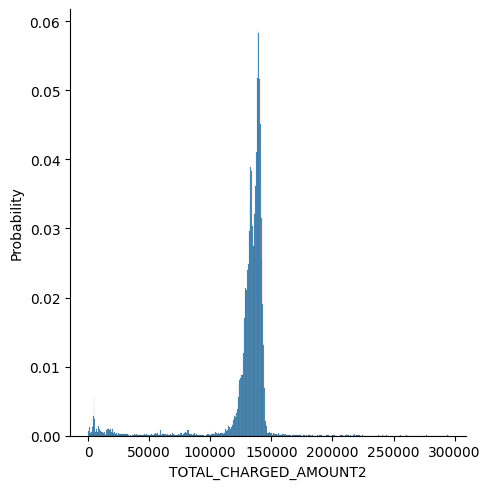

In [133]:
sns.displot(totalKg2,x="TOTAL_CHARGED_AMOUNT2",stat="probability")



In [134]:
"""totalKg3=totalKg2.copy()
totalKg3["TOTAL_CHARGED_AMOUNT2"]=totalKg3["TOTAL_CHARGED_AMOUNT2"].apply(lambda x: np.log(x + 1))

print(totalKg3)"""

#we tried doing a log transformation, but it was not effective

'totalKg3=totalKg2.copy()\ntotalKg3["TOTAL_CHARGED_AMOUNT2"]=totalKg3["TOTAL_CHARGED_AMOUNT2"].apply(lambda x: np.log(x + 1))\n\nprint(totalKg3)'

In [135]:
print("number of under-normal values:",(totalKg2['TOTAL_CHARGED_AMOUNT2'] < 20000).sum())
print("number of up-normal values:",(totalKg2['TOTAL_CHARGED_AMOUNT2'] > 220000).sum())

number of under-normal values: 640
number of up-normal values: 18


This seems like a reasonable number of rows to drop, about 3% of our dataset. It does look also like the values we are dropping are mainly mismeasurements

In [136]:
totalKg3 = totalKg2[(totalKg2['TOTAL_CHARGED_AMOUNT2'] >= 20000) & (totalKg2['TOTAL_CHARGED_AMOUNT2'] <= 200000)]


In [137]:
dfExtr4=totalKg3.merge(dfExtr3,on='HEATID',how="inner")
dfExtr5=dfExtr4.drop("TOTAL_CHARGED_AMOUNT",axis=1)

In [138]:
print(dfExtr4)

       HEATID  TOTAL_CHARGED_AMOUNT2  GAS_AMOUNT  O2_AMOUNT  \
0      5F0002                 128590      1160.0     3659.0   
1      5F0003                 128826      1117.0     3469.0   
2      5F0004                 133715      1204.0     3605.0   
3      5F0005                 129233      1191.0     3678.0   
4      5F0006                 132505      1171.0     3655.0   
...       ...                    ...         ...        ...   
20113  8F5226                 128886       584.0     3801.0   
20114  8F5227                 128737       624.0     4219.0   
20115  8F5471                 124999       717.0     4416.0   
20116  8F5472                 128222       509.0     4028.0   
20117  8F5473                 128664       522.0     4255.0   

       TOTAL_CHARGED_AMOUNT      VALC     VALSI     VALMN      VALP      VALS  \
0                    128590  0.136016  0.243730  0.425660  0.136016  0.016562   
1                    128826  0.127425  0.254487  0.424287  0.127425  0.004789   


In [139]:
Yfff=dfExtr5["MWh"]
Xfff=dfExtr5.drop(["MWh","HEATID"],axis=1)

In [140]:


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numerical_cols = Xfff.select_dtypes(include=['float64', 'int64']).columns

Xfff1 = Xfff.copy()
Xfff1[numerical_cols] = scaler.fit_transform(Xfff1[numerical_cols])

print(Xfff1.head())





   TOTAL_CHARGED_AMOUNT2  GAS_AMOUNT  O2_AMOUNT      VALC     VALSI     VALMN  \
0               0.603982    0.239175   0.193465  0.208301  0.282289  0.344880   
1               0.605295    0.230309   0.183419  0.191353  0.295507  0.343582   
2               0.632488    0.248247   0.190610  0.329515  0.332851  0.653102   
3               0.607559    0.245567   0.194469  0.204682  0.276594  0.339986   
4               0.625758    0.241443   0.193253  0.359247  0.229858  0.737373   

       VALP      VALS     VALCU     VALCR     VALMO     VALNI  
0  0.383675  0.176169  0.381434  0.321521  0.298629  0.159723  
1  0.359008  0.038473  0.355186  0.317073  0.312101  0.122958  
2  0.560097  0.297472  0.476741  0.044977  0.350163  0.101294  
3  0.378407  0.089575  0.368467  0.299040  0.292825  0.106649  
4  0.603372  0.173868  0.493011  0.037082  0.245190  0.164107  


In [141]:
from sklearn.model_selection import train_test_split
XTrainFff, XTestFff, yTrainFff, yTestFff = train_test_split(Xfff1, Yfff, test_size=0.2,random_state=42)
from sklearn.linear_model import LinearRegression
lReg1Fff = LinearRegression()
lReg1Fff.fit(XTrainFff, yTrainFff)

yPredLFff= lReg1Fff.predict(XTestFff)
my_performance_report(yPredLFff,yTestFff)

RSS:
25825.722503349214
MSE: 6.42
RMSE: 2.53
Mean Absolute Error: 1.98
Median Absolute Error: 1.63
Explained Variance Score: 0.09
R²: 0.09


In [142]:
from xgboost import XGBRegressor
xgbF = XGBRegressor(n_estimators=100).fit(XTrainFff, yTrainFff)
yPredXFff= xgbF.predict(XTestFff)
my_performance_report(yPredXFff,yTestFff)

RSS:
22327.33196489308
MSE: 5.55
RMSE: 2.36
Mean Absolute Error: 1.82
Median Absolute Error: 1.50
Explained Variance Score: 0.21
R²: 0.21


Performance does not improve, but the data we are using is more consistent.

In [143]:
from sklearn.ensemble import RandomForestRegressor

In [144]:
"""model2 = RandomForestRegressor(n_estimators=100, random_state=42).fit(XTrainFff, yTrainFff)
dump(model2,"randomForestRegressor2nd.joblib")"""

'model2 = RandomForestRegressor(n_estimators=100, random_state=42).fit(XTrainFff, yTrainFff)\ndump(model2,"randomForestRegressor2nd.joblib")'

In [145]:
model2=load("randomForestRegressor2nd.joblib")

In [146]:
yPredRFff=model2.predict(XTestFff)
my_performance_report(yPredRFff,yTestFff)

RSS:
21102.389424977504
MSE: 5.24
RMSE: 2.29
Mean Absolute Error: 1.78
Median Absolute Error: 1.44
Explained Variance Score: 0.26
R²: 0.26


In [147]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import pickle

"""modelnn = Sequential([
    Dense(128, activation='relu', input_shape=(12,)), 
    Dense(64, activation='relu'),                     
    Dense(1)                                          
])

modelnn.compile(optimizer='adam', loss='mse', metrics=['mae'])


history = modelnn.fit(XTrainFff, yTrainFff, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

modelnn.save('neuralNetworkModel1.keras')

# Guardar el historial
with open('modelnn_history1.pkl', 'wb') as file:
    pickle.dump(history.history, file)
"""

"modelnn = Sequential([\n    Dense(128, activation='relu', input_shape=(12,)), \n    Dense(64, activation='relu'),                     \n    Dense(1)                                          \n])\n\nmodelnn.compile(optimizer='adam', loss='mse', metrics=['mae'])\n\n\nhistory = modelnn.fit(XTrainFff, yTrainFff, epochs=100, batch_size=32, validation_split=0.2, verbose=0)\n\nmodelnn.save('neuralNetworkModel1.keras')\n\n# Guardar el historial\nwith open('modelnn_history1.pkl', 'wb') as file:\n    pickle.dump(history.history, file)\n"

In [148]:
modelnn = keras.models.load_model('neuralNetworkModel1.keras')

# Cargar el historial
with open('modelnn_history1.pkl', 'rb') as file:
    history = pickle.load(file)

In [ ]:
yPredNNFff=modelnn.predict(XTestFff).ravel()
my_performance_report(yPredNNFff,yTestFff)
#this values are a mistake, I will re-run this if I have time, original values were about 0.17 R2

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RSS:
34171.09273147823
MSE: 8.49
RMSE: 2.91
Mean Absolute Error: 2.17
Median Absolute Error: 1.52
Explained Variance Score: -0.03
R²: -0.20


Even though results have not improved a lot, we think we have done an important task of removing faulty values. Since it seems like the extreme values in charged amount seem to be quite important (not the faulty values we have removed, but the values between 20 and 100 tons, which we hope are not mistakes) we will keep them. After trying multiple types of scaling, Standard Scaling worked the best for us, so it is the one we will be using from now on.

We tried dropping outliers in the dependent variable, but we lost some accuracy and the values made sense, so we focused on more pressing matters. For a more thorough analysis, it could be advisable to look into them further. 

We continue treating outliers

In [150]:
out_MWhExt=find_outliers_IQR(dfExtr5,"MWh")

20118
IQR= ( 1.7554904513888872 , 14.966914062500003 )
Number of outliers for MWh: 224
Max outlier: 47.222175
Min outlier: 0.008125


We tried dropping all the outliers again, but we lost accuracy, so we are just going to drop some extreme isolated values. This will make us lose some accuracy anyway, but we feel like the dropping is justified, since these values are most likely mistakes.

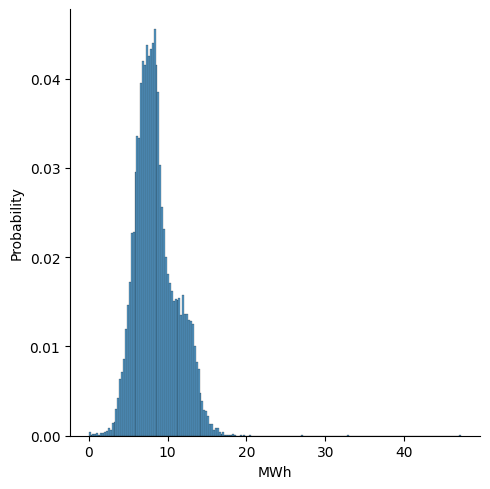

In [151]:
sns.displot(dfExtr5,x="MWh",stat="probability")

In [152]:
print("number of under-normal values:",(dfExtr5['MWh'] < 1.5).sum())
print("number of up-normal values:",(dfExtr5['MWh'] > 21).sum())

number of under-normal values: 25
number of up-normal values: 3


In [153]:
dfExtr6=dfExtr5[(dfExtr5['MWh'] >= 1.5) & (dfExtr5['MWh'] <= 21)]


Now we treat gas and oxygen outliers. 

In [154]:
out_o2Ext=find_outliers_IQR(dfExtr6,"O2_AMOUNT")

20090
IQR= ( 3006.0 , 5542.0 )
Number of outliers for O2_AMOUNT: 326
Max outlier: 18913.0
Min outlier: 979.0


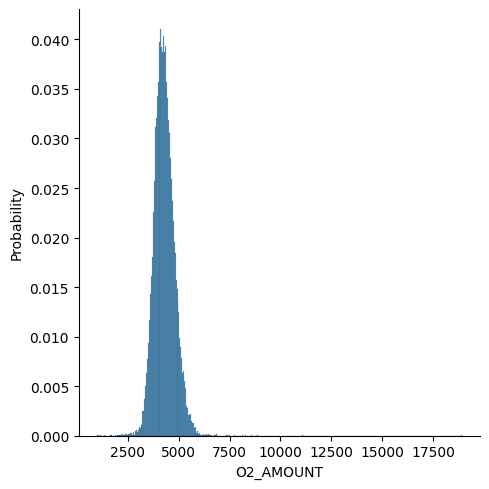

In [155]:
sns.displot(dfExtr6,x="O2_AMOUNT",stat="probability")

For both columns, it seemed like we lost vital information dropping the outliers, so we will not touch them. We will, however, perform a square root transformation to try to mitigate some of the sparsity of the data.

In [156]:
dfExtr7=dfExtr6.copy()

dfExtr7['O2_AMOUNT'] = np.sqrt(dfExtr6['O2_AMOUNT'])

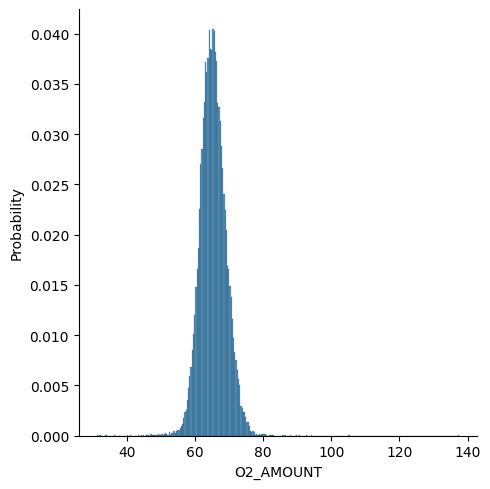

In [157]:
sns.displot(dfExtr7,x="O2_AMOUNT",stat="probability")

In [158]:
out_o2Ex2=find_outliers_IQR(dfExtr7,"O2_AMOUNT")

20090
IQR= ( 55.62634682425599 , 75.03526145094992 )
Number of outliers for O2_AMOUNT: 280
Max outlier: 137.5245432641025
Min outlier: 31.28897569432403


In [159]:
Ymax=dfExtr7["MWh"]
Xmax=dfExtr7.drop(["MWh","HEATID"],axis=1)

In [160]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_cols = Xmax.select_dtypes(include=['float64', 'int64']).columns

Xmax1 = Xmax.copy()
Xmax1[numerical_cols] = scaler.fit_transform(Xmax1[numerical_cols])

print(Xmax1.head())



   TOTAL_CHARGED_AMOUNT2  GAS_AMOUNT  O2_AMOUNT      VALC     VALSI     VALMN  \
0              -0.336741    2.614297  -1.274638 -0.694751  0.124102 -0.855928   
1              -0.320139    2.337109  -1.688350 -0.801798  0.233040 -0.861843   
2               0.023784    2.897931  -1.391104  0.070862  0.540814  0.548100   
3              -0.291508    2.814130  -1.233864 -0.717613  0.077167 -0.878221   
4              -0.061335    2.685205  -1.283235  0.258661 -0.308010  0.931977   

       VALP      VALS     VALCU     VALCR     VALMO     VALNI  
0  4.620839 -0.529441  0.039019  2.640678  4.904990 -0.665700  
1  4.301038 -1.912458 -0.350339  2.593153  5.147124 -1.205249  
2  6.908103  0.688926  1.452802 -0.313950  5.831207 -1.523170  
3  4.552542 -1.399191 -0.153321  2.400481  4.800669 -1.444583  
4  7.469153 -0.552551  1.694147 -0.398294  3.944543 -0.601359  


In [161]:
from sklearn.model_selection import train_test_split
XTrainMax, XTestMax, yTrainMax, yTestMax = train_test_split(Xmax1, Ymax, test_size=0.2,random_state=42)
from sklearn.linear_model import LinearRegression
lReg1Max = LinearRegression()
lReg1Max.fit(XTrainMax, yTrainMax)

yPredLMax= lReg1Max.predict(XTestMax)
my_performance_report(yPredLMax,yTestMax)




RSS:
24072.63473424092
MSE: 5.99
RMSE: 2.45
Mean Absolute Error: 1.93
Median Absolute Error: 1.61
Explained Variance Score: 0.09
R²: 0.09


In [162]:
from xgboost import XGBRegressor
xgbM = XGBRegressor(n_estimators=100).fit(XTrainMax, yTrainMax)
yPredXMax= xgbM.predict(XTestMax)
my_performance_report(yPredXMax,yTestMax)

RSS:
21092.079591239977
MSE: 5.25
RMSE: 2.29
Mean Absolute Error: 1.79
Median Absolute Error: 1.46
Explained Variance Score: 0.21
R²: 0.21


In [163]:
from sklearn.ensemble import RandomForestRegressor
"""modelMax = RandomForestRegressor(n_estimators=100, random_state=42).fit(XTrainMax, yTrainMax)
dump(modelMax,"randomforestregressor3.joblib")"""

'modelMax = RandomForestRegressor(n_estimators=100, random_state=42).fit(XTrainMax, yTrainMax)\ndump(modelMax,"randomforestregressor3.joblib")'

In [164]:
modelMax=load("randomforestregressor3.joblib")

In [165]:
yPredRMax=modelMax.predict(XTestMax)
my_performance_report(yPredRMax,yTestMax)

RSS:
19920.250897287224
MSE: 4.96
RMSE: 2.23
Mean Absolute Error: 1.73
Median Absolute Error: 1.42
Explained Variance Score: 0.25
R²: 0.25


In [166]:
print(XTestMax) 

       TOTAL_CHARGED_AMOUNT2  GAS_AMOUNT  O2_AMOUNT      VALC     VALSI  \
8907                0.389234    0.293655  -0.930304 -0.236680 -0.154298   
2813                0.530067    0.106715  -0.106137  0.810473 -0.227164   
1606               -0.113391    0.184069  -1.897218  0.130045 -0.031857   
10607               0.490392    0.158285  -0.058201  0.633800 -0.346182   
19872              -0.249230   -0.853773  -0.198396  1.144283 -0.934968   
...                      ...         ...        ...       ...       ...   
6590               -0.354820    0.222747  -0.773365  0.061653 -0.610663   
720                 0.147875    0.603074  -0.715162  0.110688 -0.394518   
4340                0.395916   -0.408983  -0.513070 -0.019473 -0.632020   
34                 -0.091865   -0.441214  -0.609681  1.446507 -0.107904   
15913               0.034899   -0.202704   0.114440 -0.275530 -0.475875   

          VALMN       VALP      VALS     VALCU     VALCR     VALMO     VALNI  
8907  -1.123888  -0.

Now that we have more or less the preprocessing we wanted to do, it is time to start fine-tuning our models. When we have a satisfactory result for each of our models, we will create an ensemble model that hopefully can capture all the good things each method has.

MODEL AND PARAMETER TUNING.

L1 and L2 regression. 

In [167]:
print(dfExtr7)

       HEATID  TOTAL_CHARGED_AMOUNT2  GAS_AMOUNT  O2_AMOUNT      VALC  \
0      5F0002                 128590      1160.0  60.489669  0.136016   
1      5F0003                 128826      1117.0  58.898217  0.127425   
2      5F0004                 133715      1204.0  60.041652  0.197456   
3      5F0005                 129233      1191.0  60.646517  0.134181   
4      5F0006                 132505      1171.0  60.456596  0.212527   
...       ...                    ...         ...        ...       ...   
20113  8F5226                 128886       584.0  61.652251  0.134793   
20114  8F5227                 128737       624.0  64.953830  0.106340   
20115  8F5471                 124999       717.0  66.452991  0.100659   
20116  8F5472                 128222       509.0  63.466527  0.134531   
20117  8F5473                 128664       522.0  65.230361  0.116805   

          VALSI     VALMN      VALP      VALS     VALCU     VALCR     VALMO  \
0      0.243730  0.425660  0.136016  0.01656

In [168]:
Xtune=dfExtr7.drop(["HEATID","MWh"],axis=1)
yTune=dfExtr7["MWh"]

In [169]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_cols = Xtune.select_dtypes(include=['float64', 'int64']).columns

Xtune1 = Xtune.copy()
Xtune1[numerical_cols] = scaler.fit_transform(Xtune1[numerical_cols])

print(Xtune1.head())

   TOTAL_CHARGED_AMOUNT2  GAS_AMOUNT  O2_AMOUNT      VALC     VALSI     VALMN  \
0              -0.336741    2.614297  -1.274638 -0.694751  0.124102 -0.855928   
1              -0.320139    2.337109  -1.688350 -0.801798  0.233040 -0.861843   
2               0.023784    2.897931  -1.391104  0.070862  0.540814  0.548100   
3              -0.291508    2.814130  -1.233864 -0.717613  0.077167 -0.878221   
4              -0.061335    2.685205  -1.283235  0.258661 -0.308010  0.931977   

       VALP      VALS     VALCU     VALCR     VALMO     VALNI  
0  4.620839 -0.529441  0.039019  2.640678  4.904990 -0.665700  
1  4.301038 -1.912458 -0.350339  2.593153  5.147124 -1.205249  
2  6.908103  0.688926  1.452802 -0.313950  5.831207 -1.523170  
3  4.552542 -1.399191 -0.153321  2.400481  4.800669 -1.444583  
4  7.469153 -0.552551  1.694147 -0.398294  3.944543 -0.601359  


In [170]:
from sklearn.model_selection import train_test_split
XTrainTune, XTestTune, yTrainTune, yTestTune = train_test_split(Xtune1, yTune, test_size=0.2,random_state=42)


In [171]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

"""elastic_net = ElasticNet(max_iter=10000)

param_grid = {
    'alpha': [0.1, 1, 10, 100],  
    'l1_ratio': [0.1, 0.5, 0.7, 1.0] 
}

grid_searchL1L2 = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

grid_searchL1L2.fit(XTrainTune, yTrainTune)
dump(grid_searchL1L2,"elasticGridSearchTune.joblib")"""


'elastic_net = ElasticNet(max_iter=10000)\n\nparam_grid = {\n    \'alpha\': [0.1, 1, 10, 100],  \n    \'l1_ratio\': [0.1, 0.5, 0.7, 1.0] \n}\n\ngrid_searchL1L2 = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring=\'r2\', n_jobs=-1)\n\ngrid_searchL1L2.fit(XTrainTune, yTrainTune)\ndump(grid_searchL1L2,"elasticGridSearchTune.joblib")'

In [172]:
grid_searchL1L2=load("elasticGridSearchTune.joblib")

In [173]:

# Resultados
print("Best parameters found:", grid_searchL1L2.best_params_)
print("Best R2 score in cross validation:", grid_searchL1L2.best_score_)


Best parameters found: {'alpha': 0.1, 'l1_ratio': 0.1}
Best R2 score in cross validation: 0.08921073496876034


In [174]:
y_predTuneL1L2 = grid_searchL1L2.best_estimator_.predict(XTestTune)
my_performance_report(y_predTuneL1L2,yTestTune)

RSS:
24135.240628560976
MSE: 6.01
RMSE: 2.45
Mean Absolute Error: 1.94
Median Absolute Error: 1.60
Explained Variance Score: 0.09
R²: 0.09


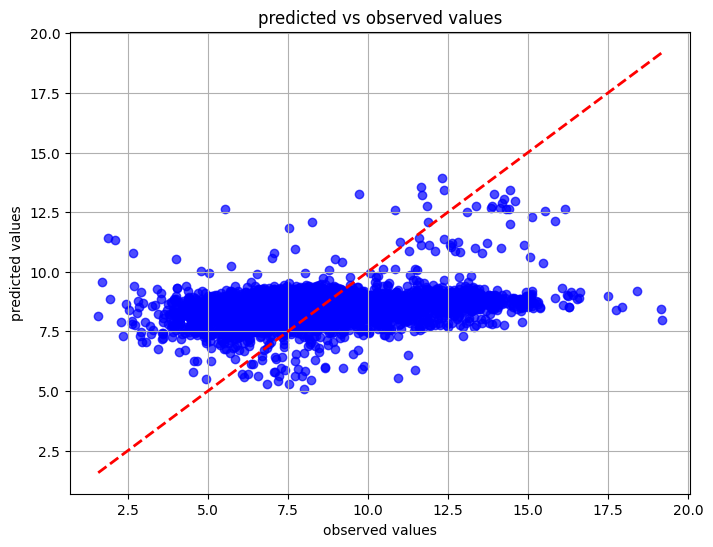

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



plt.figure(figsize=(8, 6))
plt.scatter(yTestTune, y_predTuneL1L2, alpha=0.7, color="blue")
plt.plot([yTestTune.min(), yTestTune.max()], [yTestTune.min(), yTestTune.max()], 'r--', lw=2)
plt.title("predicted vs observed values")
plt.xlabel("observed values")
plt.ylabel("predicted values")
plt.grid()
plt.show()




XGBOOST

In [176]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint

"""# Definir el modelo
xgb_modelTune = xgb.XGBRegressor()

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Realizar la búsqueda aleatoria
random_searchTuneXgb = RandomizedSearchCV(estimator=xgb_modelTune, param_distributions=param_dist, n_iter=120, scoring='r2', cv=3, random_state=42)
random_searchTuneXgb.fit(XTrainTune, yTrainTune)"""



"# Definir el modelo\nxgb_modelTune = xgb.XGBRegressor()\n\n# Definir el espacio de hiperparámetros\nparam_dist = {\n    'n_estimators': randint(100, 500),\n    'learning_rate': uniform(0.01, 0.2),\n    'max_depth': randint(3, 10),\n    'min_child_weight': randint(1, 10),\n    'subsample': uniform(0.7, 0.3),\n    'colsample_bytree': uniform(0.7, 0.3)\n}\n\n# Realizar la búsqueda aleatoria\nrandom_searchTuneXgb = RandomizedSearchCV(estimator=xgb_modelTune, param_distributions=param_dist, n_iter=120, scoring='r2', cv=3, random_state=42)\nrandom_searchTuneXgb.fit(XTrainTune, yTrainTune)"

In [177]:
#dump(random_searchTuneXgb,"xgbRandomSearchTune.joblib")

In [178]:
random_searchTuneXgb=load("xgbRandomSearchTune.joblib")

In [179]:
print("Best parameters found:", random_searchTuneXgb.best_params_)
print("Best R2 score in cross validation:", random_searchTuneXgb.best_score_)

Best parameters found: {'colsample_bytree': np.float64(0.7964748294040087), 'learning_rate': np.float64(0.028458117245749218), 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 313, 'subsample': np.float64(0.7245277095846615)}
Best R2 score in cross validation: 0.24338944041996072


In [180]:
y_predTuneXgb = random_searchTuneXgb.best_estimator_.predict(XTestTune)
my_performance_report(y_predTuneXgb,yTestTune)

RSS:
19534.973968508788
MSE: 4.86
RMSE: 2.20
Mean Absolute Error: 1.72
Median Absolute Error: 1.40
Explained Variance Score: 0.26
R²: 0.26


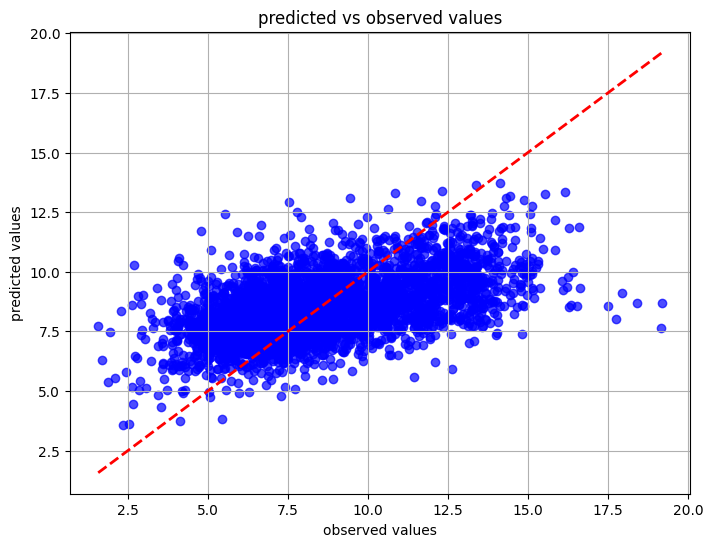

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



plt.figure(figsize=(8, 6))
plt.scatter(yTestTune, y_predTuneXgb, alpha=0.7, color="blue")
plt.plot([yTestTune.min(), yTestTune.max()], [yTestTune.min(), yTestTune.max()], 'r--', lw=2)
plt.title("predicted vs observed values")
plt.xlabel("observed values")
plt.ylabel("predicted values")
plt.grid()
plt.show()

Random Forest.

In [182]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

"""rf_modelRandomTune = RandomForestRegressor(random_state=42)

param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

random_searchTuneRF = RandomizedSearchCV(estimator=rf_modelRandomTune, param_distributions=param_dist_rf, n_iter=80, scoring='r2', cv=3, random_state=42)

random_searchTuneRF.fit(XTrainTune, yTrainTune)"""

"rf_modelRandomTune = RandomForestRegressor(random_state=42)\n\nparam_dist_rf = {\n    'n_estimators': randint(100, 500),\n    'max_depth': randint(3, 10),\n    'min_samples_split': randint(2, 10),\n    'min_samples_leaf': randint(1, 10),\n    'bootstrap': [True, False]\n}\n\nrandom_searchTuneRF = RandomizedSearchCV(estimator=rf_modelRandomTune, param_distributions=param_dist_rf, n_iter=80, scoring='r2', cv=3, random_state=42)\n\nrandom_searchTuneRF.fit(XTrainTune, yTrainTune)"

In [183]:
#dump(random_searchTuneRF,"RandomForestRandomSearchTune.joblib")


In [184]:
random_searchTuneRF=load("RandomForestRandomSearchTune.joblib")


In [185]:
print("Best parameters found:", random_searchTuneRF.best_params_)
print("Best R2 score in cross validation:", random_searchTuneRF.best_score_)

Best parameters found: {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 451}
Best R2 score in cross validation: 0.21803286982878775


In [186]:
y_predTuneRandFor = random_searchTuneRF.best_estimator_.predict(XTestTune)
my_performance_report(y_predTuneRandFor,yTestTune)

RSS:
20421.194820805813
MSE: 5.08
RMSE: 2.25
Mean Absolute Error: 1.76
Median Absolute Error: 1.45
Explained Variance Score: 0.23
R²: 0.23


We get a worst score on Random Forest than what we should. Let's repeat with a different grid search.

In [187]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [188]:
"""rfTune2 = RandomForestRegressor(random_state=42)

# Búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rfTune2, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(XTrainMax, yTrainMax)"""


"rfTune2 = RandomForestRegressor(random_state=42)\n\n# Búsqueda en cuadrícula\ngrid_search = GridSearchCV(estimator=rfTune2, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)\ngrid_search.fit(XTrainMax, yTrainMax)"

In [189]:
#dump(grid_search,"RandomForestGridSearchTuneSecond.joblib")

In [190]:
grid_search=load("RandomForestGridSearchTuneSecond.joblib")


In [191]:

print("Best parameters found:", grid_search.best_params_)
print("Best MSE score in cross validation:", grid_search.best_score_)

Best parameters found: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best MSE score in cross validation: -4.904288809085196


In [192]:

y_predTuneRandFor2 = grid_search.best_estimator_.predict(XTestTune)
my_performance_report(y_predTuneRandFor2,yTestTune)

RSS:
19653.570312435295
MSE: 4.89
RMSE: 2.21
Mean Absolute Error: 1.72
Median Absolute Error: 1.41
Explained Variance Score: 0.26
R²: 0.26


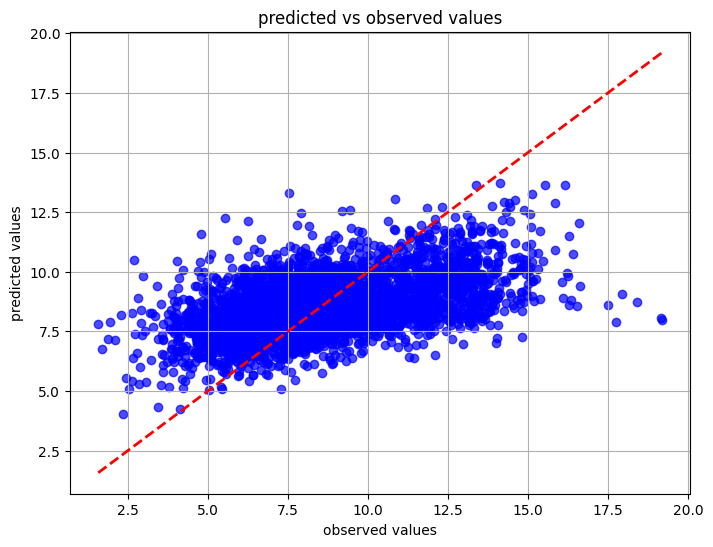

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



plt.figure(figsize=(8, 6))
plt.scatter(yTestTune, y_predTuneRandFor2, alpha=0.7, color="blue")
plt.plot([yTestTune.min(), yTestTune.max()], [yTestTune.min(), yTestTune.max()], 'r--', lw=2)
plt.title("predicted vs observed values")
plt.xlabel("observed values")
plt.ylabel("predicted values")
plt.grid()
plt.show()            

Let's see how we do with more estimators.

In [194]:
param_grid3rf = {
    'n_estimators': [300,350,400,450,500],
    'max_depth': [None],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'bootstrap': [False]
}

Neural networks. 

In Neural networks I will do parameter tuning manually.

In [195]:
"""rfTune3 = RandomForestRegressor(random_state=42)

# Búsqueda en cuadrícula
grid_searchrf3Tune = GridSearchCV(estimator=rfTune3, param_grid=param_grid3rf, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_searchrf3Tune.fit(XTrainMax, yTrainMax)"""

"rfTune3 = RandomForestRegressor(random_state=42)\n\n# Búsqueda en cuadrícula\ngrid_searchrf3Tune = GridSearchCV(estimator=rfTune3, param_grid=param_grid3rf, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)\ngrid_searchrf3Tune.fit(XTrainMax, yTrainMax)"

In [196]:
#dump(grid_searchrf3Tune,"RandomForestGridSearchTuneThird.joblib")

In [197]:
grid_searchrf3Tune=load("RandomForestGridSearchTuneThird.joblib")


In [198]:
print("Best parameters found:", grid_searchrf3Tune.best_params_)
print("Best MSE score in cross validation:", grid_searchrf3Tune.best_score_)


Best parameters found: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 450}
Best MSE score in cross validation: -4.899322526943309


In [199]:

y_predTuneRandFor3 = grid_searchrf3Tune.best_estimator_.predict(XTestTune)
my_performance_report(y_predTuneRandFor3,yTestTune)

RSS:
19610.992340967925
MSE: 4.88
RMSE: 2.21
Mean Absolute Error: 1.72
Median Absolute Error: 1.40
Explained Variance Score: 0.26
R²: 0.26


In [200]:
import kerastuner as kt
from keras import layers
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam


"""# Define a model-building function
def build_model(hp):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(XTrainTune.shape[1],)))
    
    # Agregar capas ocultas con unidades ajustables
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    
    model.add(layers.Dense(1)) 
    
    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='LOG')), 
                  loss='mse', metrics=['mae'])
    
    return model

# Inicializar el tunner RandomSearch
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory=R'C:\Users\quinito\ACADEMIA\ano academico suecia\Data Mining\Project DM\my_dir',
                     project_name='intro_to_kt'
                     )


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Realizar la búsqueda, haciendo que 'epochs' sea un parámetro variable
tuner.search(
    XTrainTune, 
    yTrainTune, 
    epochs=50,  
    validation_split=0.15)
"""



SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 846-847: truncated \UXXXXXXXX escape (667239339.py, line 43)

In [214]:
# Obtener el mejor modelo
#best_model = tuner.get_best_models(1)[0]

C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [219]:
#best_model.save('neuralSearchTune.keras')

In [220]:
best_model = keras.models.load_model('neuralSearchTune.keras')

C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [221]:
y_predTuneNnLowEpoch = best_model.predict(XTestTune).ravel()
my_performance_report(y_predTuneNnLowEpoch,yTestTune)

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RSS:
21011.338960941674
MSE: 5.23
RMSE: 2.29
Mean Absolute Error: 1.78
Median Absolute Error: 1.45
Explained Variance Score: 0.21
R²: 0.21


We have seen how the best model that we could find until now does. Let's see if we can get a little bit more value out of the hyperparameters of the model

In [202]:

# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [222]:
#dump(best_hps,"bestHyperParamTunerNN.pkl")

['bestHyperParamTunerNN.pkl']

In [223]:
best_hps=load("bestHyperParamTunerNN.pkl")

In [211]:
print(f"Optimal number of layers: {best_hps.get('num_layers')}")
print(f"Optimal units per layer: {best_hps.get('units')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

Optimal number of layers: 3
Optimal units per layer: 96
Optimal learning rate: 0.0003047566454213899


In [210]:
print(best_hps)

In [203]:
"""modelnnTune = tuner.hypermodel.build(best_hps)
historynnTune = modelnnTune.fit(XTrainTune, yTrainTune, epochs=150, validation_split=0.15)"""

Epoch 1/150


C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


427/427 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 32.9649 - mae: 4.5857 - val_loss: 7.1922 - val_mae: 2.0911
Epoch 2/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6241 - mae: 2.0060 - val_loss: 6.3022 - val_mae: 1.9605
Epoch 3/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9414 - mae: 1.9134 - val_loss: 5.9951 - val_mae: 1.9149
Epoch 4/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4850 - mae: 1.8350 - val_loss: 5.7392 - val_mae: 1.8831
Epoch 5/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4105 - mae: 1.8434 - val_loss: 5.6154 - val_mae: 1.8664
Epoch 6/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2428 - mae: 1.8037 - val_loss: 5.5889 - val_mae: 1.8636
Epoch 7/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.2416 - mae: 1.7975 - val_loss: 5.6070 - val_mae: 1.8735
Epoch 8/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2632 - mae: 1.8093 - val_loss: 5.4934 - val_mae: 1.8335
Epoch 9/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss

In [224]:
"""modelnnTune.save('modelnnTuneHyperparamrebuild.keras')

with open('modelnnTuneHyperparamrebuild_history.pkl', 'wb') as file:
    pickle.dump(historynnTune.history, file)"""

In [ ]:
modelnn = keras.models.load_model('modelnnTuneHyperparamrebuild.keras')

# Cargar el historial
with open('modelnnTuneHyperparamrebuild_history.pkl', 'rb') as file:
    historynnTune = pickle.load(file)

In [204]:
val_acc_per_epoch = historynnTune.history['val_loss']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 33


In [ ]:
"""hypermodel = tuner.hypermodel.build(best_hps)

hypermodel.fit(XTrainTune, yTrainTune, epochs=best_epoch, validation_split=0.15)"""

C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/33
427/427 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 30.2985 - mae: 4.4022 - val_loss: 7.5273 - val_mae: 2.1389
Epoch 2/33
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6026 - mae: 2.0077 - val_loss: 6.3525 - val_mae: 1.9948
Epoch 3/33
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9811 - mae: 1.9127 - val_loss: 5.9352 - val_mae: 1.9170
Epoch 4/33
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5912 - mae: 1.8643 - val_loss: 5.7831 - val_mae: 1.9170
Epoch 5/33
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.3273 - mae: 1.8274 - val_loss: 5.6201 - val_mae: 1.8594
Epoch 6/33
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3084 - mae: 1.8162 - val_loss: 5.5703 - val_mae: 1.8481
Epoch 7/33
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2142 - mae: 1.7984 - val_loss: 5.5190 - val_mae: 1.8577
Epoch 8/33
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1481 - mae: 1.7860 - val_loss: 5.5408 - val_mae: 1.8774
Epoch 9/33
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - l

In [225]:
#hypermodel.save('modelnnTuneHyperparamrebuildOptEpochs.keras')

In [226]:
hypermodel = keras.models.load_model('modelnnTuneHyperparamrebuildOptEpochs.keras')

In [218]:
y_predTuneNnLowEpoch = hypermodel.predict(XTestTune).ravel()
my_performance_report(y_predTuneNnLowEpoch,yTestTune)

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RSS:
21268.31852789565
MSE: 5.29
RMSE: 2.30
Mean Absolute Error: 1.77
Median Absolute Error: 1.42
Explained Variance Score: 0.23
R²: 0.20


Let's see if we can build a similar neural network with better accuracy manually.

In [270]:
"""modelnnLast = Sequential([
    Dense(128, activation='relu', input_shape=(12,)), 
    Dense(96, activation='relu'),            
    Dense(64, activation='relu'),           
    Dense(1)                                          
])

optimizerMine = Adam(learning_rate=0.0005)  


modelnnLast.compile(optimizerMine, loss='mse', metrics=['mae'])


history = modelnnLast.fit(XTrainTune, yTrainTune, epochs=28, batch_size=32, validation_split=0.15, verbose=0)"""

C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [272]:
"""modelnnLast.save('modelnnLast.keras')

with open('modelnnLast_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)"""



In [273]:
modelnnLast = keras.models.load_model('modelnnLast.keras')

with open('modelnnLast_history.pkl', 'rb') as file:
    history = pickle.load(file)

In [274]:
y_predTuneNNLast = modelnnLast.predict(XTestTune).ravel()
my_performance_report(y_predTuneNNLast,yTestTune)

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RSS:
20773.233694788687
MSE: 5.17
RMSE: 2.27
Mean Absolute Error: 1.79
Median Absolute Error: 1.48
Explained Variance Score: 0.22
R²: 0.22


Now we will run an ensemble that hopefully can combine the strengths of all our previous models.

In [289]:
ensemble_prediction = (0.4*y_predTuneRandFor3 + 0.4*y_predTuneXgb + 0.2*y_predTuneNNLast)

In [290]:
my_performance_report(ensemble_prediction,yTestTune)

RSS:
19320.88323595978
MSE: 4.81
RMSE: 2.19
Mean Absolute Error: 1.71
Median Absolute Error: 1.41
Explained Variance Score: 0.27
R²: 0.27


Our ensemble is a little bit better than the separate models. This is not a great result, but it shows that we can explain at least some of the variance in energy. Also, taking into account the broadness of our dependent variable (From 0.5 to 18 MWh), our error does not seem so bad. 